# Making Graphs for the Path of a Single Simulant

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 100)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

### Create interactive sim data 
#### Note: I have saved an old version of this data, you can choose to skip this step and just load the dataset below

Limit this to people of more interest (older) and do a small population for a long time since we aren't looking for population level information 

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [4]:
"""
    outreach:
        exposure: 0
    polypill:
        exposure: 0
    lifestyle:
        exposure: 0
    intervention:
        scenario: "polypill_100"
    outreach_scale_up: 
        date:
            start:
                year: 2021
                month: 1
                day: 1
            end:
                year: 2022
                month: 1
                day: 1
        value:
            start: 0
            end: 0
    polypill_scale_up: 
        date:
            start:
                year: 2021
                month: 1
                day: 1
            end:
                year: 2022
                month: 1
                day: 1
        value:
            start: 0
            end: 1
    lifestyle_scale_up:
        date:
            start:
                year: 2021
                month: 1
                day: 1
            end:
                year: 2022
                month: 1
                day: 1
        value:
            start: 0
            end: 0
"""

'\n    outreach:\n        exposure: 0\n    polypill:\n        exposure: 0\n    lifestyle:\n        exposure: 0\n    intervention:\n        scenario: "polypill_100"\n    outreach_scale_up: \n        date:\n            start:\n                year: 2021\n                month: 1\n                day: 1\n            end:\n                year: 2022\n                month: 1\n                day: 1\n        value:\n            start: 0\n            end: 0\n    polypill_scale_up: \n        date:\n            start:\n                year: 2021\n                month: 1\n                day: 1\n            end:\n                year: 2022\n                month: 1\n                day: 1\n        value:\n            start: 0\n            end: 1\n    lifestyle_scale_up:\n        date:\n            start:\n                year: 2021\n                month: 1\n                day: 1\n            end:\n                year: 2022\n                month: 1\n                day: 1\n        value:\n 

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 100,
                               'age_start': 50,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              },
                          'input_data':
                              {'input_draw_number': 829
                              }
                          }
                        )
sim.setup()

2023-08-10 12:24:00.568 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-08-10 12:24:00.570 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 829'].
2023-08-10 12:24:00.574 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
#pop0

In [7]:
#sim.list_values()

data1 = pd.concat([pop0,
                   sim.get_value('outreach.exposure')(pop0.index),
                   sim.get_value('lifestyle.exposure')(pop0.index),
                   sim.get_value('polypill.exposure')(pop0.index),
                  ], axis=1)
data1.head()

In [5]:
sim_data = pd.DataFrame()
for step in list(range(0,240)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                      ], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [6]:
sim_data.polypill.unique()

array(['cat2', 'cat1'], dtype=object)

In [7]:
sim_data.to_csv('/ihme/homes/lutzes/sim_graphs_240_steps_polypill_08102023.csv')

In [9]:
#sim_data.to_csv('/ihme/homes/lutzes/sim_graphs_240_steps_baseline_08072023.csv')

## Analyze Data and Set Up Columns for Graphing 

In [2]:
full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_240_steps_baseline_08072023.csv')
full_data_polypill = pd.read_csv('/ihme/homes/lutzes/sim_graphs_240_steps_polypill_08102023.csv')

#full_data.head()

/tmp/ipykernel_3999451/4083521288.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_240_steps_baseline_08072023.csv')
/tmp/ipykernel_3999451/4083521288.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_polypill = pd.read_csv('/ihme/homes/lutzes/sim_graphs_240_steps_polypill_08102023.csv')


In [3]:
test_data = full_data.loc[(full_data.age > 25)]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data = test_data.rename(columns={'Unnamed: 0':'sim_id'})

In [4]:
test_data_polypill = full_data_polypill.loc[(full_data_polypill.age > 25)]
test_data_polypill['age_start'] = ((test_data_polypill.age/5).astype(int) * 5).astype(float)
test_data_polypill = test_data_polypill.rename(columns={'Unnamed: 0':'sim_id'})

In [82]:
event_data = test_data[['sim_id','exit_time','sex','alive','age_start','cause_of_death','years_of_life_lost','years_lived_with_disability','ischemic_stroke','ischemic_heart_disease_and_heart_failure','outreach','lifestyle','polypill','sbp_medication','sbp_medication_adherence','ldlc_medication','ldlc_medication_adherence','scheduled_date','visit_type','step','high_sbp','high_ldl','high_bmi','high_fpg']]
event_data_polypill = test_data_polypill[['sim_id','exit_time','sex','alive','age_start','cause_of_death','years_of_life_lost','years_lived_with_disability','ischemic_stroke','ischemic_heart_disease_and_heart_failure','outreach','lifestyle','polypill','sbp_medication','sbp_medication_adherence','ldlc_medication','ldlc_medication_adherence','scheduled_date','visit_type','step','high_sbp','high_ldl','high_bmi','high_fpg']]
event_data.head()

sim_id exit_time     sex  alive  age_start cause_of_death  \
0       0       NaN  Female  alive       65.0       not_dead   
1       1       NaN    Male  alive       60.0       not_dead   
2       2       NaN  Female  alive       65.0       not_dead   
3       3       NaN    Male  alive       55.0       not_dead   
4       4       NaN  Female  alive       50.0       not_dead   

   years_of_life_lost  years_lived_with_disability  \
0                 0.0                          0.0   
1                 0.0                          0.0   
2                 0.0                          0.0   
3                 0.0                          0.0   
4                 0.0                          0.0   

                  ischemic_stroke  \
0  susceptible_to_ischemic_stroke   
1  susceptible_to_ischemic_stroke   
2  susceptible_to_ischemic_stroke   
3  susceptible_to_ischemic_stroke   
4  susceptible_to_ischemic_stroke   

            ischemic_heart_disease_and_heart_failure  ...  \
0  susceptible_to_ischemic_heart_disease_and_hear...  ...   
1  susceptible_to_ischemic_heart_disease_and_hear...  ...   
2  susceptible_to_ischemic_heart_disease_and_hear...  ...   
3  susceptible_to_ischemic_heart_disease_and_hear...  ...   
4  susceptible_to_ischemic_heart_disease_and_hear...  ...   

  sbp_medication_adherence   ldlc_medication ldlc_medication_adherence  \
0                     cat3      no_treatment                      cat3   
1                     cat3      no_treatment                      cat3   
2                     cat3  medium_intensity                      cat3   
3                     cat1    high_intensity                      cat3   
4                     cat3      no_treatment                      cat2   

                  scheduled_date  visit_type step    high_sbp  high_ldl  \
0  2021-06-15 21:37:52.737139200  background    0   95.619533  4.444570   
1                            NaN        none    0   78.462494  4.163244   
2                            NaN        none    0  123.899256  2.468695   
3                            NaN        none    0  103.719982  3.154417   
4                            NaN        none    0  100.763227  4.533727   

    high_bmi  high_fpg  
0  33.674540  5.527681  
1  32.581674  5.682910  
2  31.431516  7.702176  
3  32.005203  4.978965  
4  33.458323  4.037111  

[5 rows x 24 columns]

In [44]:
event_data = event_data.sort_values(['sim_id','step'])
event_data['ldl_change'] = np.where(event_data['ldlc_medication'] != event_data['ldlc_medication'].shift(1), event_data['step'],0)
event_data['sbp_change'] = np.where(event_data['sbp_medication'] != event_data['sbp_medication'].shift(1), event_data['step'],0)
event_data['polypill_start'] = np.where(event_data['polypill'] != event_data['polypill'].shift(1), event_data['step'],0)
#event_data.loc[event_data.sim_id == 19]

In [83]:
event_data_polypill = event_data_polypill.sort_values(['sim_id','step'])
event_data_polypill['ldl_change'] = np.where(event_data_polypill['ldlc_medication'] != event_data_polypill['ldlc_medication'].shift(1), event_data_polypill['step'],0)
event_data_polypill['sbp_change'] = np.where(event_data_polypill['sbp_medication'] != event_data_polypill['sbp_medication'].shift(1), event_data_polypill['step'],0)
event_data_polypill['polypill_start'] = np.where(event_data_polypill['polypill'] != event_data_polypill['polypill'].shift(1), event_data_polypill['step'],0)

In [24]:
#event_data.loc[event_data.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']

## Creating the Graphs

In [95]:
single_sim = event_data.loc[(event_data['sim_id']==11)]
single_sim.loc[single_sim.step == 100]#.lifestyle #.head()

sim_id   exit_time     sex alive  age_start          cause_of_death  \
10011      11  2028-08-04  Female  dead       65.0  heart_failure_residual   

       years_of_life_lost  years_lived_with_disability  \
10011           22.351232                     1.803681   

               ischemic_stroke ischemic_heart_disease_and_heart_failure  ...  \
10011  chronic_ischemic_stroke                   heart_failure_residual  ...   

      sbp_medication_adherence  ldlc_medication ldlc_medication_adherence  \
10011                     cat3     no_treatment                      cat3   

                      scheduled_date visit_type step    high_sbp  high_ldl  \
10011  2028-09-13 17:58:49.009526400       none  100  144.807565  5.498628   

        high_bmi   high_fpg  
10011  41.154402  12.908438  

[1 rows x 24 columns]

In [94]:
single_sim_polypill = event_data_polypill.loc[(event_data_polypill['sim_id']==11)]
single_sim_polypill.loc[single_sim_polypill.step == 195]#.lifestyle #.head()

sim_id   exit_time     sex alive  age_start           cause_of_death  \
19511      11  2036-01-11  Female  dead       75.0  chronic_ischemic_stroke   

       years_of_life_lost  years_lived_with_disability  \
19511           16.160506                     3.416488   

               ischemic_stroke  \
19511  chronic_ischemic_stroke   

                ischemic_heart_disease_and_heart_failure  ...  \
19511  susceptible_to_ischemic_heart_disease_and_hear...  ...   

                      scheduled_date  visit_type step    high_sbp high_ldl  \
19511  2036-01-30 08:52:08.909443200        none  195  147.733634      5.5   

        high_bmi   high_fpg ldl_change sbp_change  polypill_start  
19511  38.507174  13.177618          0          0               0  

[1 rows x 27 columns]

In [75]:
def visits(single_sim):
    background = single_sim.step.loc[(single_sim.visit_type=='background') & (single_sim.alive=='alive')]
    background_y = [175] * len(background)
    scheduled = single_sim.step.loc[(single_sim.visit_type=='scheduled') & (single_sim.alive=='alive')]
    scheduled_y = [175] * len(scheduled)
    emergency = single_sim.step.loc[(single_sim.visit_type=='emergency') & (single_sim.alive=='alive')]
    emergency_y = [175] * len(emergency)
    return background, background_y, scheduled, scheduled_y, emergency, emergency_y

In [70]:
def meds(single_sim):
    ldl_med = single_sim.ldl_change.loc[single_sim.ldl_change!=0]
    ldl_y = [195] * len(ldl_med)
    sbp_med = single_sim.sbp_change.loc[single_sim.sbp_change!=0]
    sbp_y = [195] * len(sbp_med)
    return ldl_med, ldl_y, sbp_med, sbp_y

In [28]:
def lifestyle_func(single_sim):
    lifestyle = single_sim.step.loc[single_sim.lifestyle.notna()]
    if len(lifestyle > 0): 
        lifestyle = lifestyle.iloc[0]
        lifestyle_y = [12]
    else:
        lifestyle_y = []
    return lifestyle, lifestyle_y

In [29]:
def polypill_func(single_sim):
    polypill = single_sim.polypill_start.loc[single_sim.polypill_start!=0]
    return polypill

In [71]:
def sbp_func(single_sim):
    sbp_base = single_sim.iloc[0].high_sbp 
    sbp_base = round(sbp_base)
    sbp = single_sim['high_sbp'] #((single_sim['high_sbp'] - sbp_base) / 5) + 7
    return sbp, sbp_base

In [31]:
def ldl_func(single_sim):
    ldl_base = single_sim.iloc[0].high_ldl 
    ldl_base = round(ldl_base,1)
    ldl = ((single_sim['high_ldl'] - ldl_base) / 3) + 8
    return ldl, ldl_base

In [32]:
def bmi_func(single_sim):
    bmi_base = single_sim.iloc[0].high_bmi 
    bmi_base = round(bmi_base,1)
    bmi = ((single_sim['high_bmi'] - bmi_base) / 5) + 6
    return bmi, bmi_base

In [33]:
def fpg_func(single_sim):
    fpg_base = single_sim.iloc[0].high_fpg 
    fpg_base = round(fpg_base,1)
    fpg = ((single_sim['high_fpg'] - fpg_base) / 3) + 4
    return fpg, fpg_base

In [76]:
def health_events(single_sim): 
    died = single_sim.step.loc[single_sim.alive=='dead']
    if len(died > 0): 
        died = died.iloc[0]
        died_y = [55]
    else: 
        died_y = []
    MI = single_sim.step.loc[single_sim.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']
    MI = MI[1:].values.tolist()
    MI[:] = [x for x in MI if x <= died]
    MI_y = [55] * len(MI)
    HF = single_sim.step.loc[(single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_residual') | (single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_from_ischemic_heart_disease')]
    if len(HF > 0): 
        HF = HF.iloc[0]
        HF_y = [55]
    else: 
        HF_y = []
    stroke = single_sim.step.loc[single_sim.ischemic_stroke=='acute_ischemic_stroke']
    stroke_y = [55] * len(stroke)
    if (MI or len(stroke > 0)):
        died = died + 1
    return died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y

In [86]:
def health_events_baseline(single_sim): 
    died = single_sim.step.loc[single_sim.alive=='dead']
    if len(died > 0): 
        died = died.iloc[0]
        died_y = [45]
    else: 
        died_y = []
    MI = single_sim.step.loc[single_sim.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']
    MI = MI[1:].values.tolist()
    MI[:] = [x for x in MI if x <= died]
    MI_y = [45] * len(MI)
    HF = single_sim.step.loc[(single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_residual') | (single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_from_ischemic_heart_disease')]
    if len(HF > 0): 
        HF = HF.iloc[0]
        HF_y = [45]
    else: 
        HF_y = []
    stroke = single_sim.step.loc[single_sim.ischemic_stroke=='acute_ischemic_stroke']
    stroke_y = [45] * len(stroke)
    if (MI or len(stroke > 0)):
        died = died + 1
    return died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y

KeyboardInterrupt: 

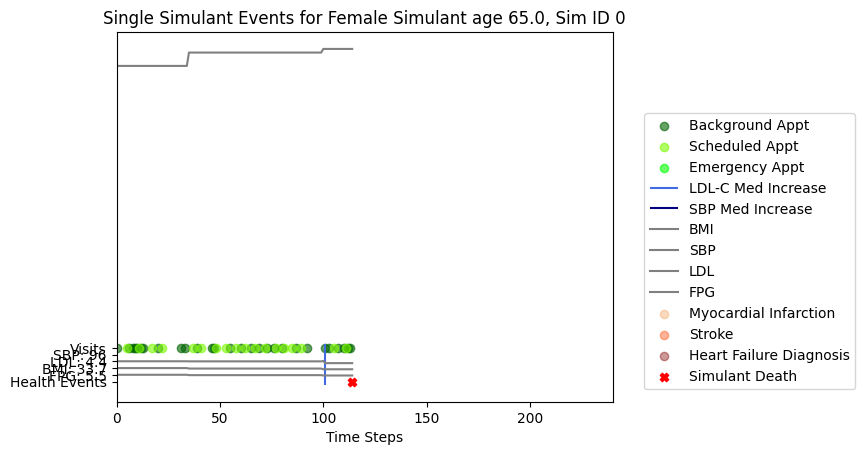

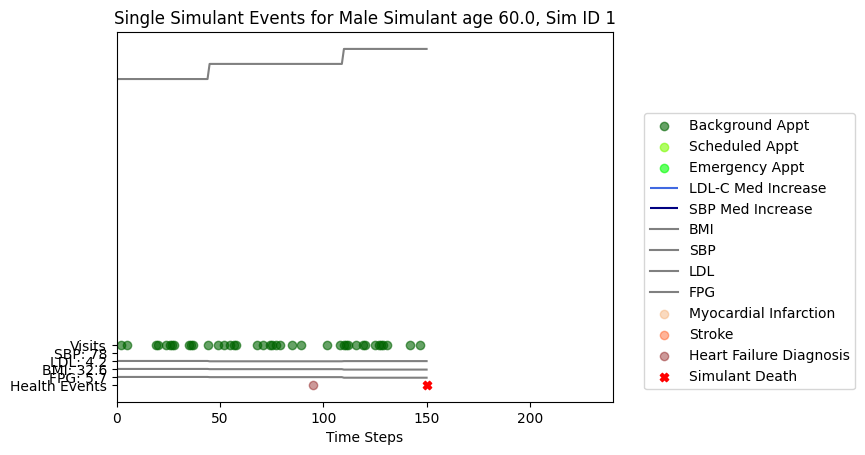

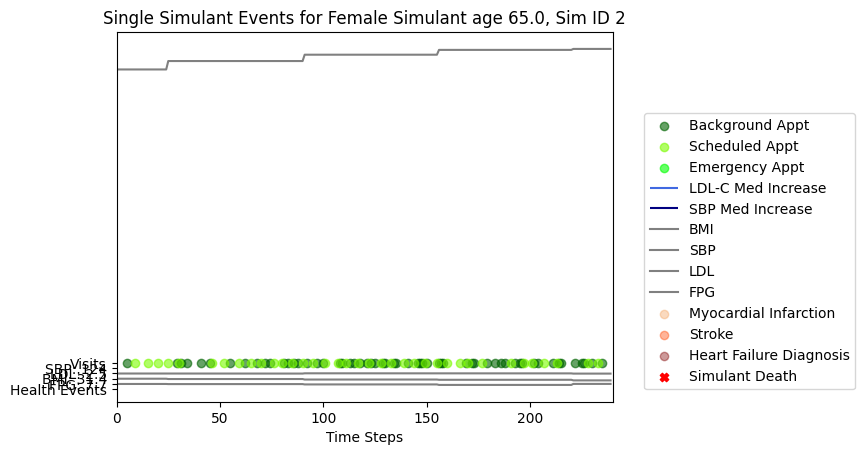

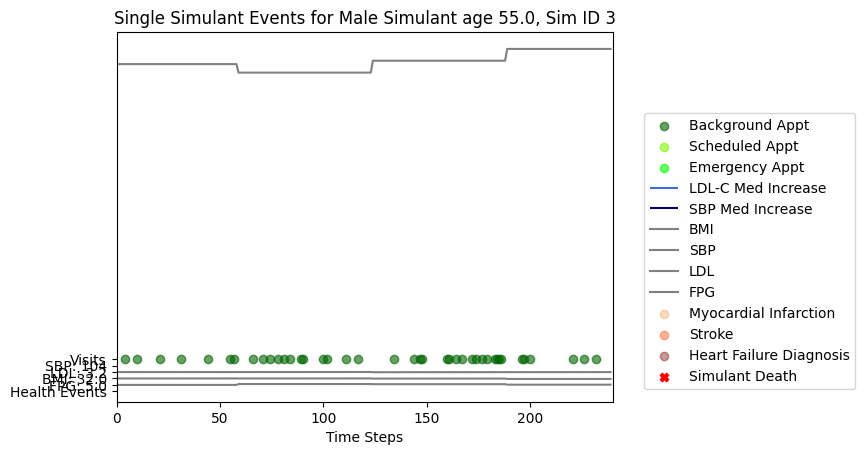

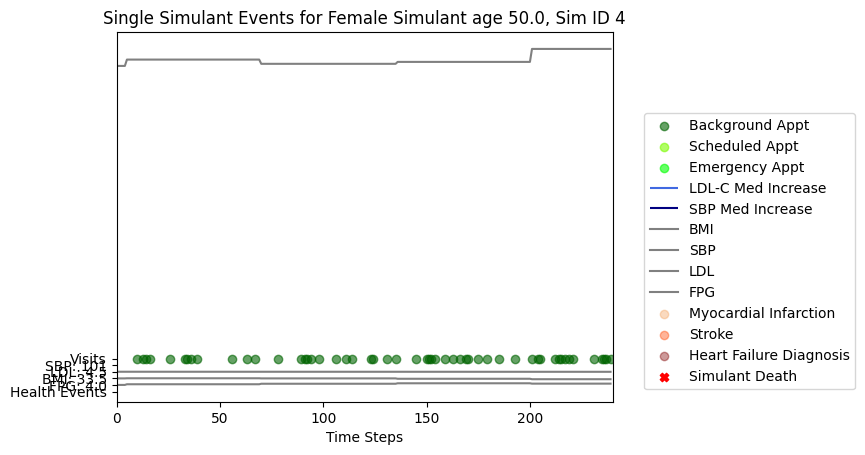

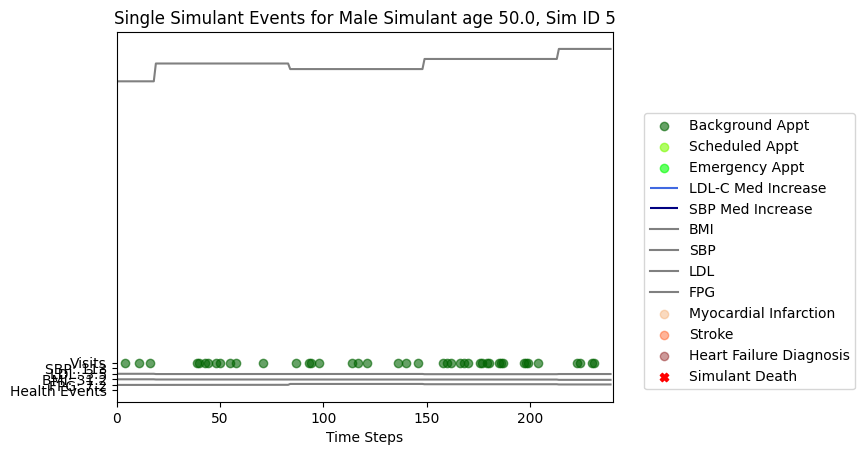

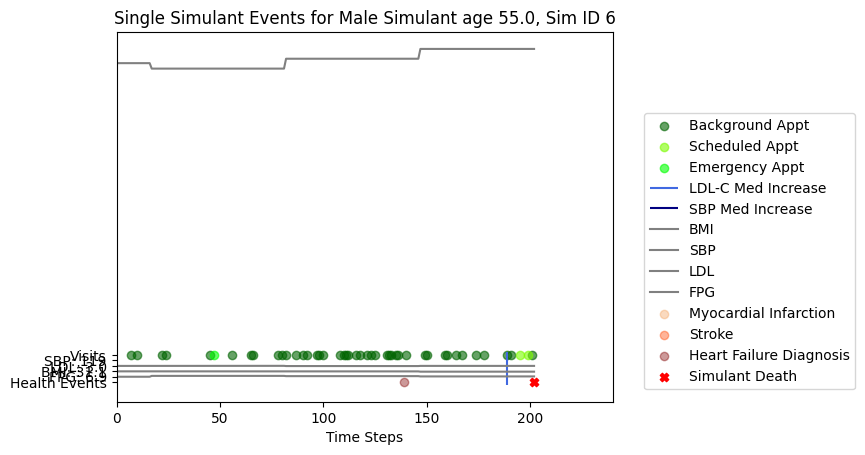

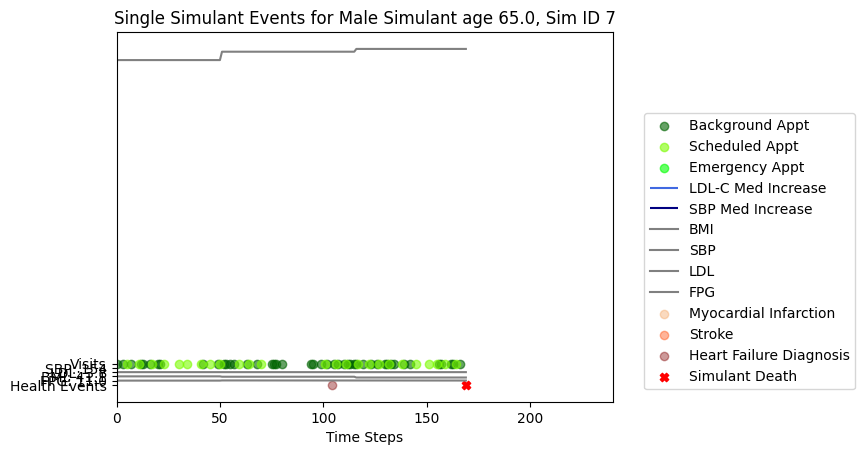

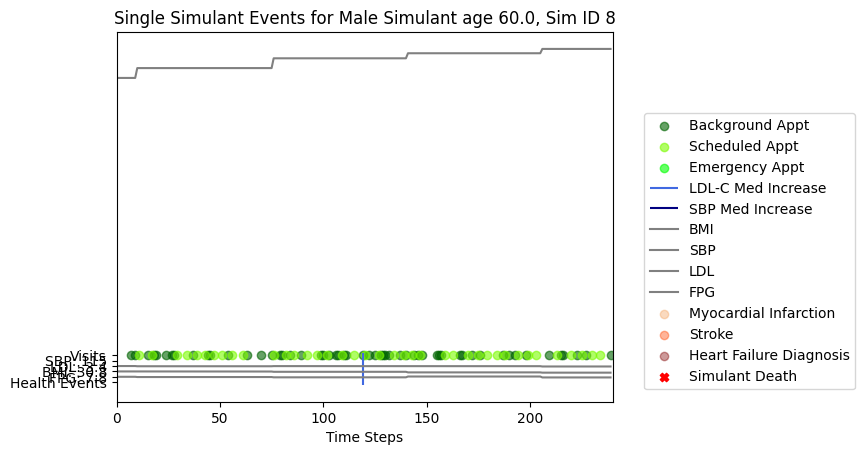

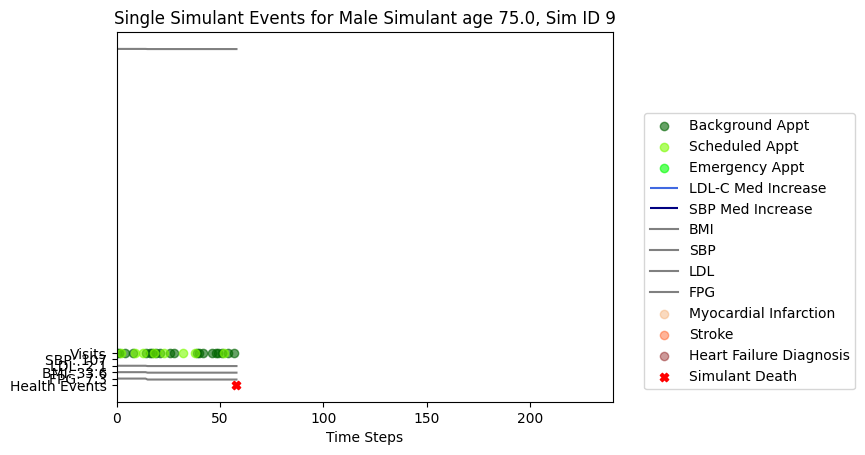

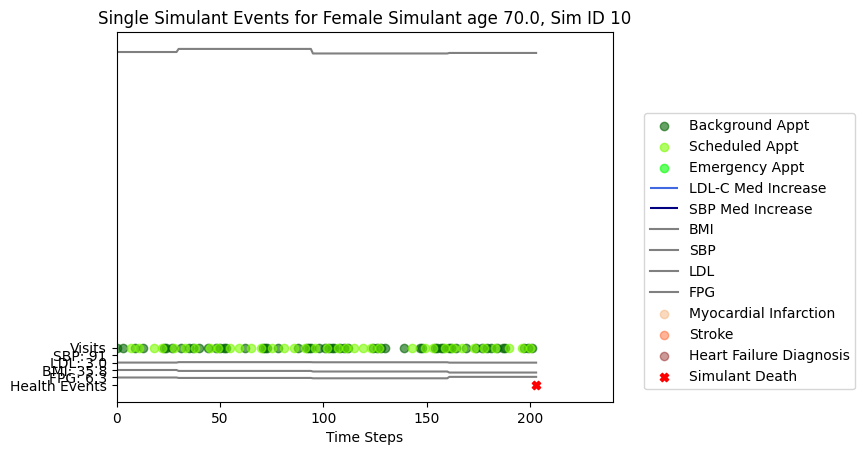

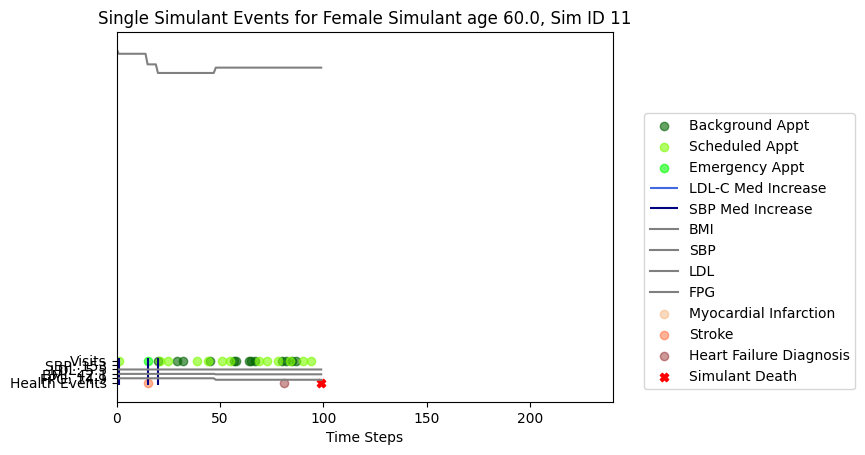

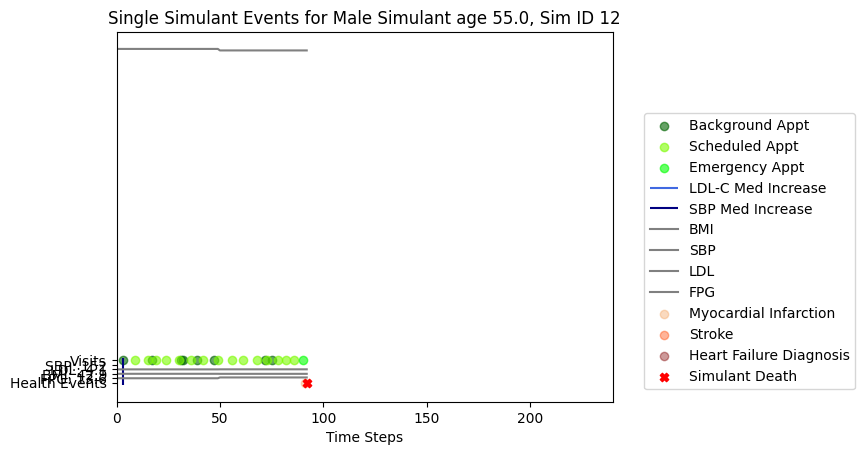

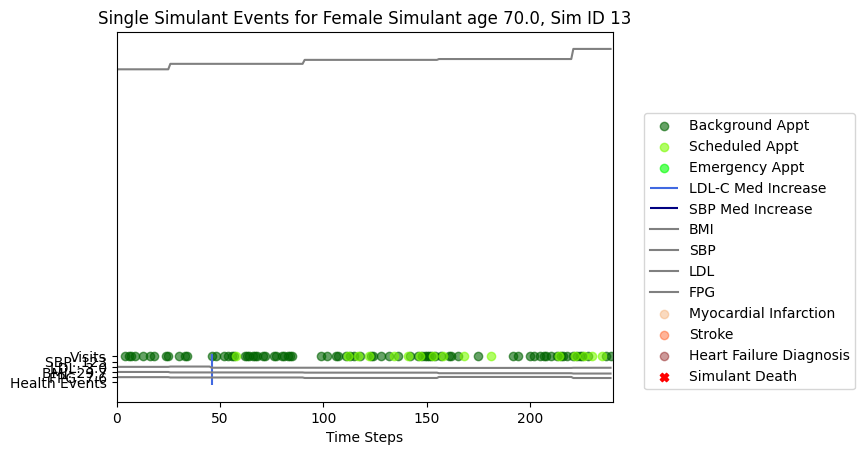

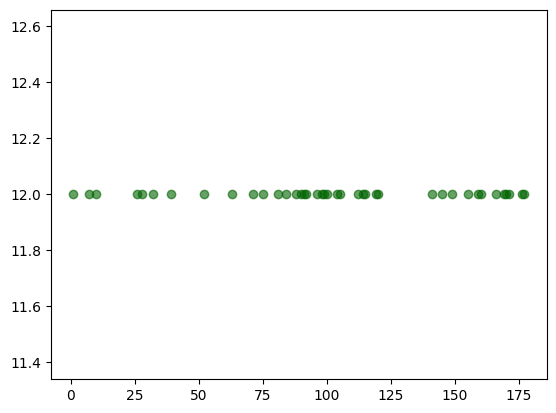

In [66]:
## Baseline graph -  no interventions, all risk factors 

with PdfPages('single_sim_events_100_sims_baseline.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        #plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        #plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

In [ ]:
## Lifestyle Graphs - only include BMI and FPG 

with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

/tmp/ipykernel_2604965/3605287286.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


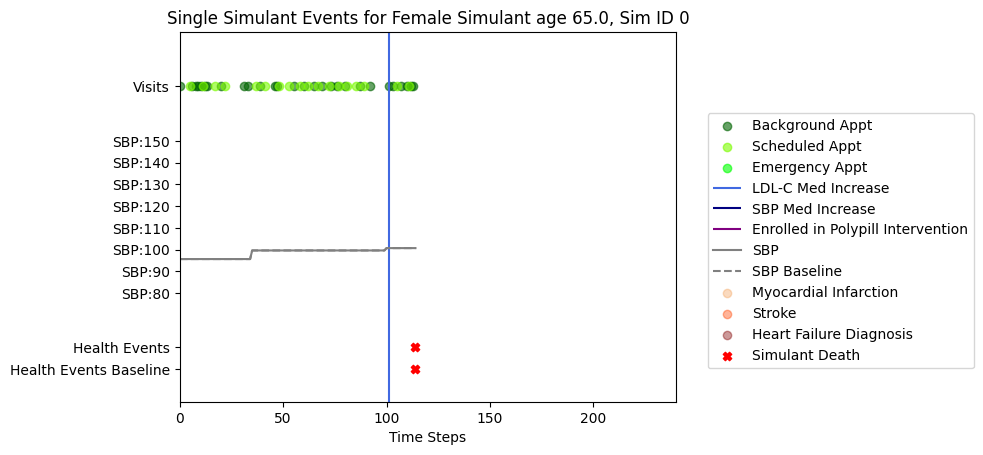

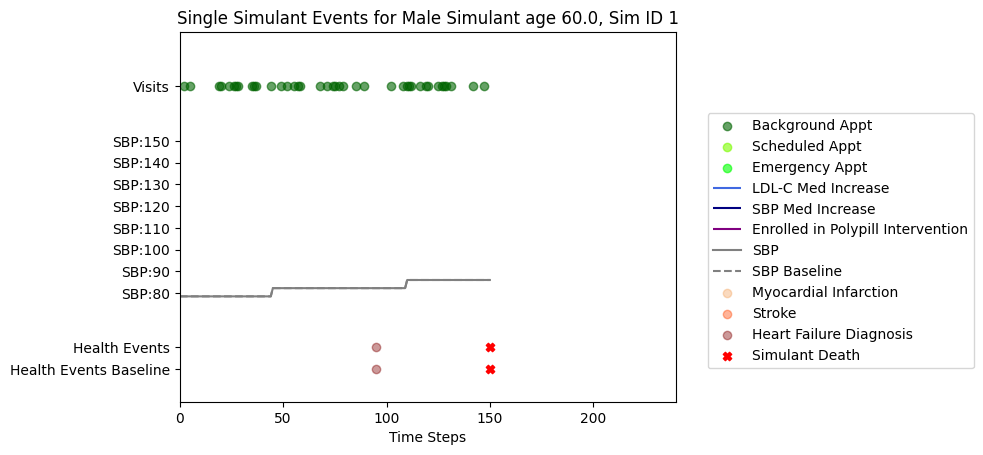

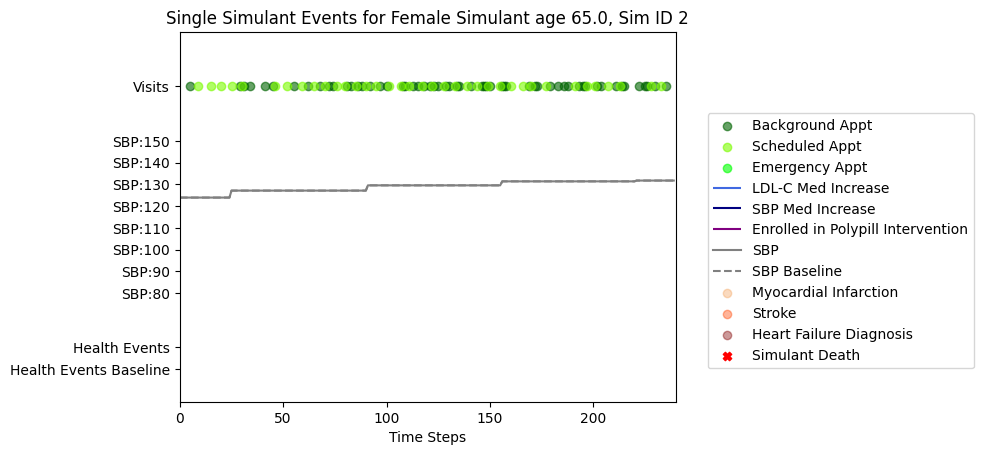

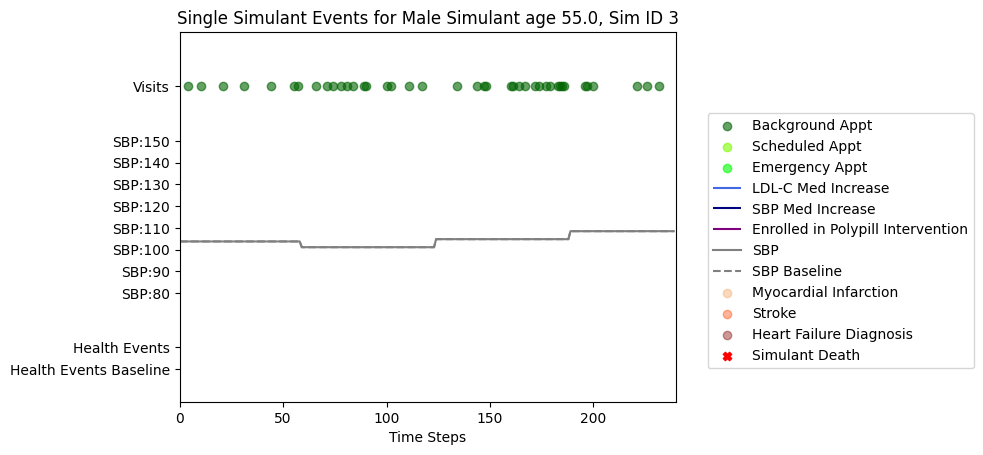

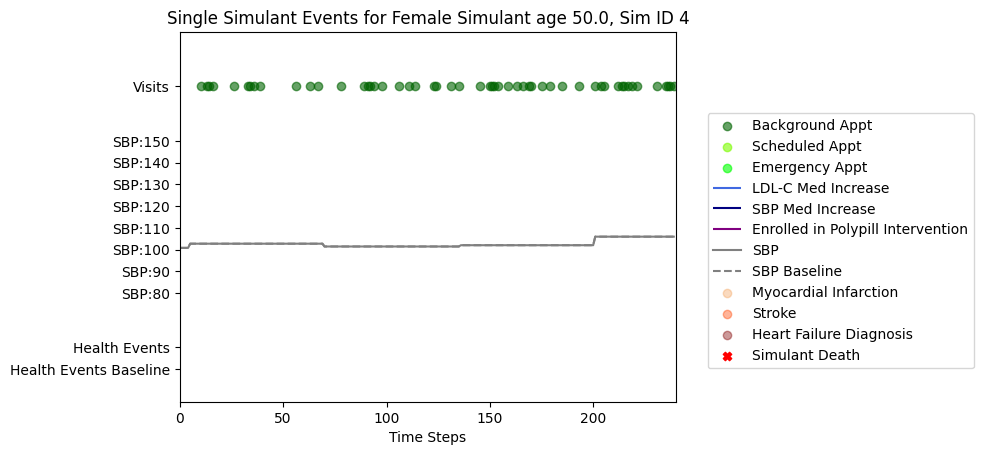

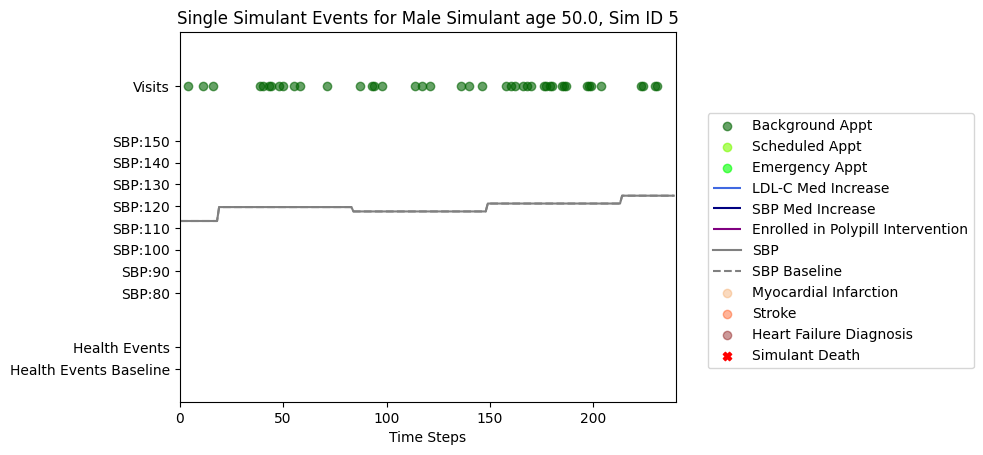

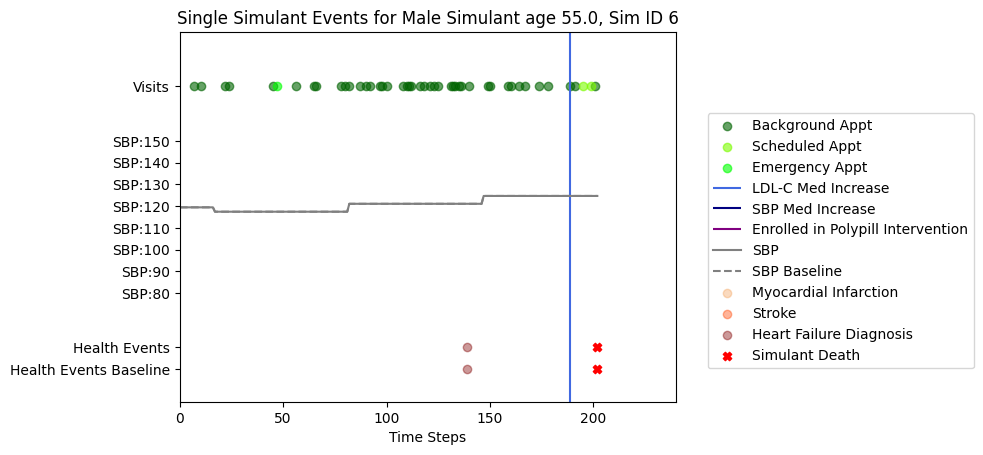

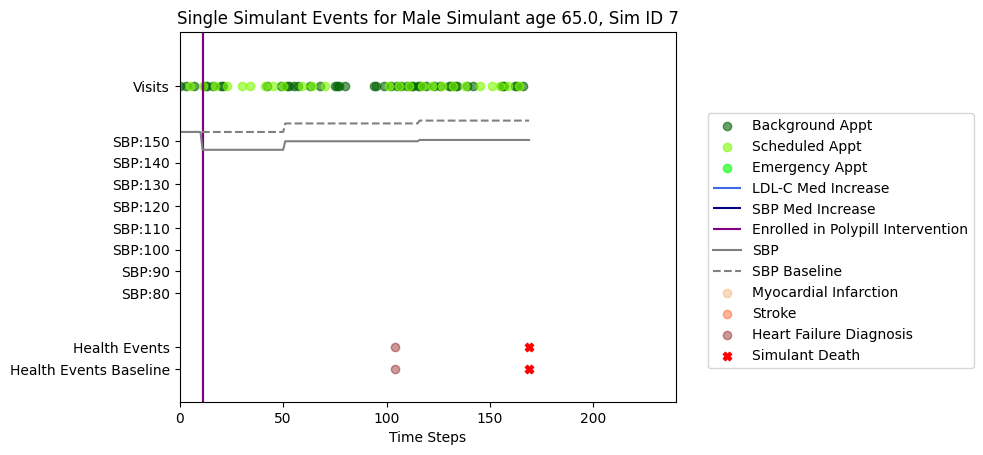

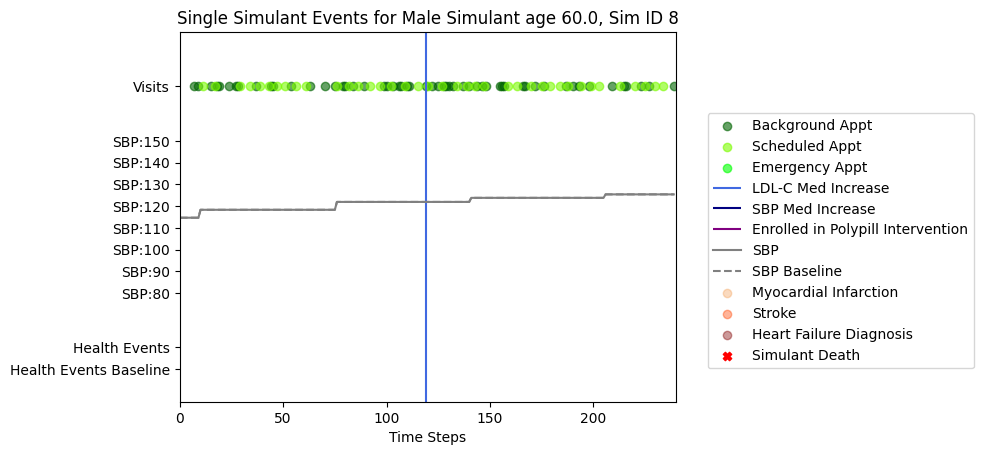

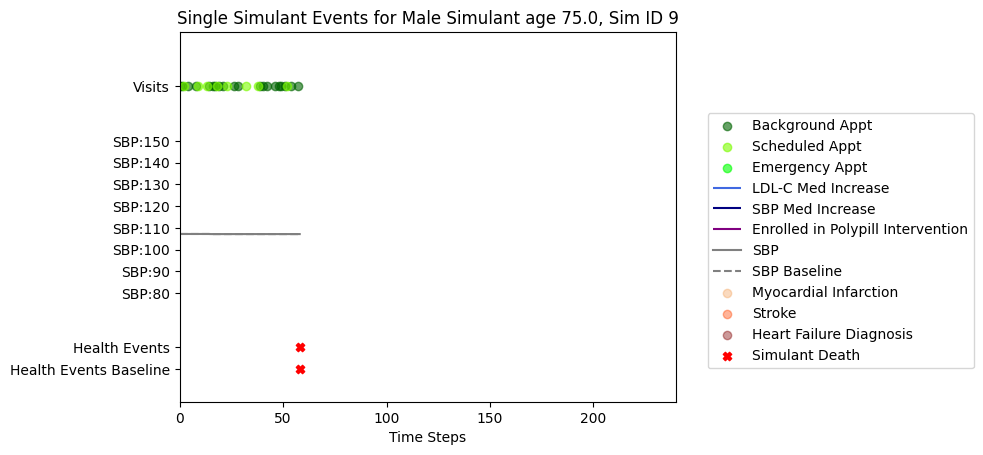

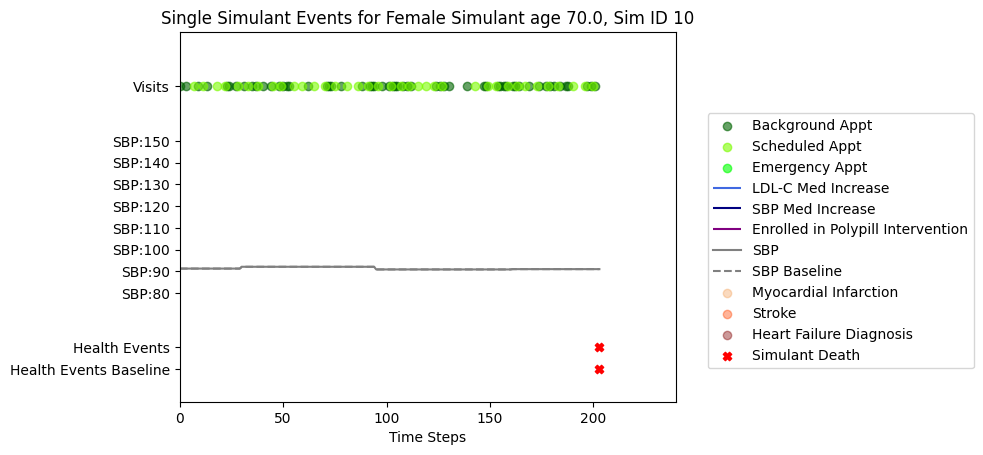

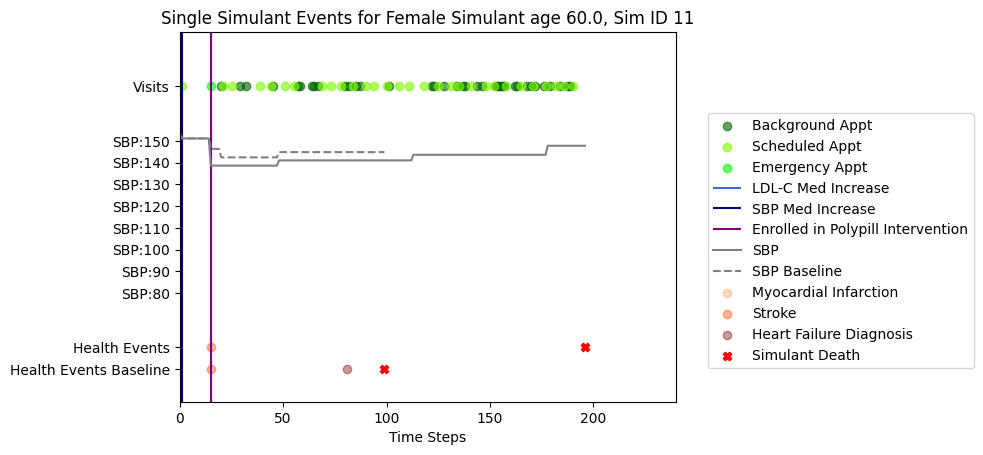

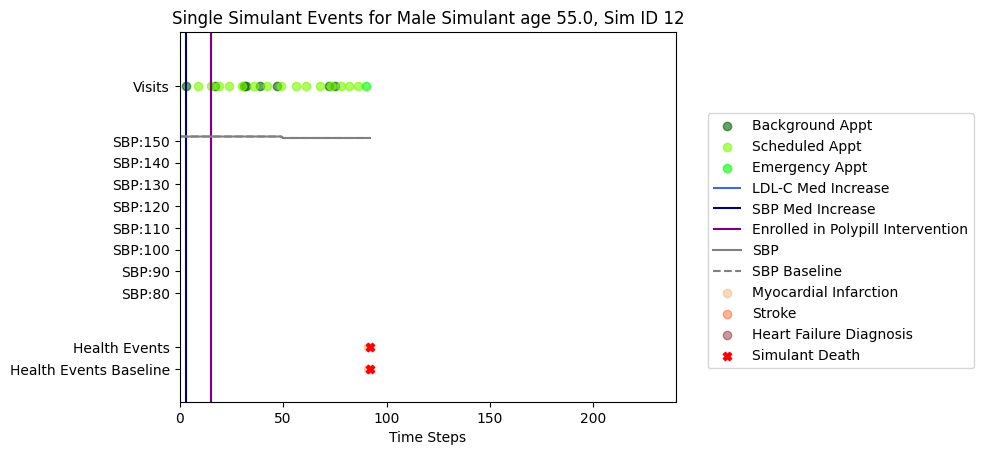

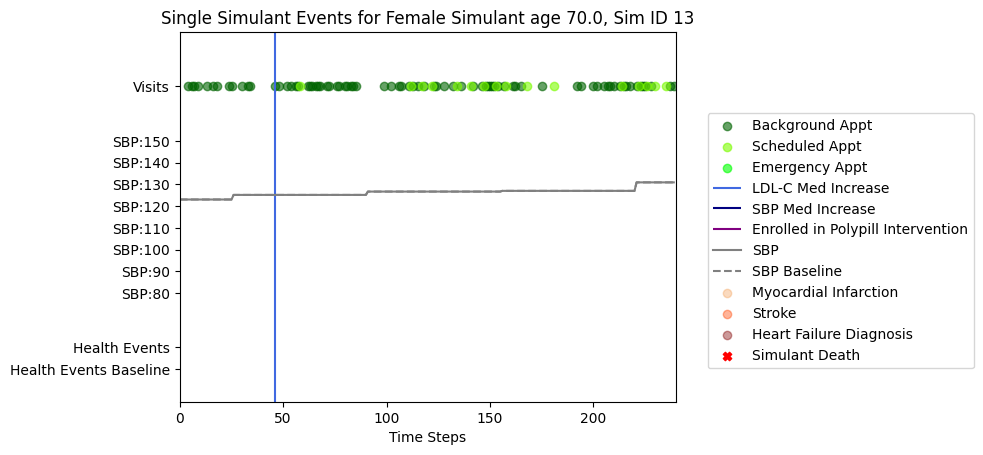

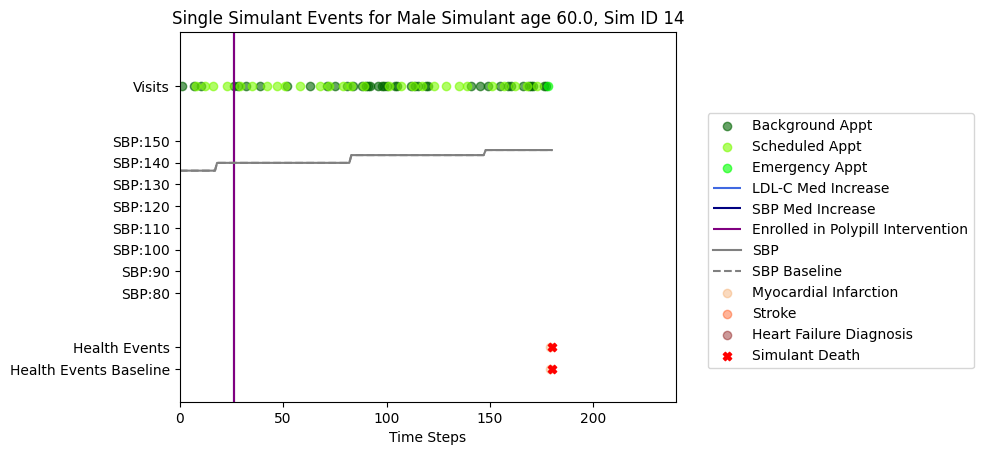

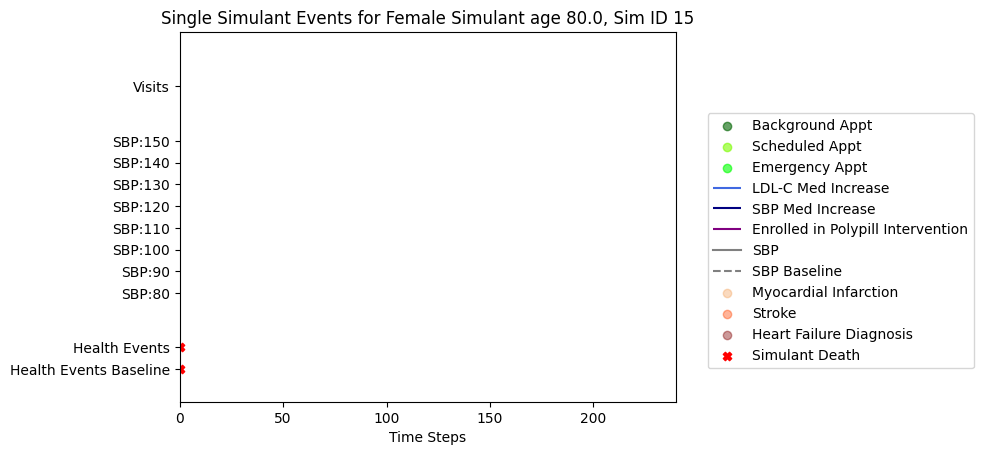

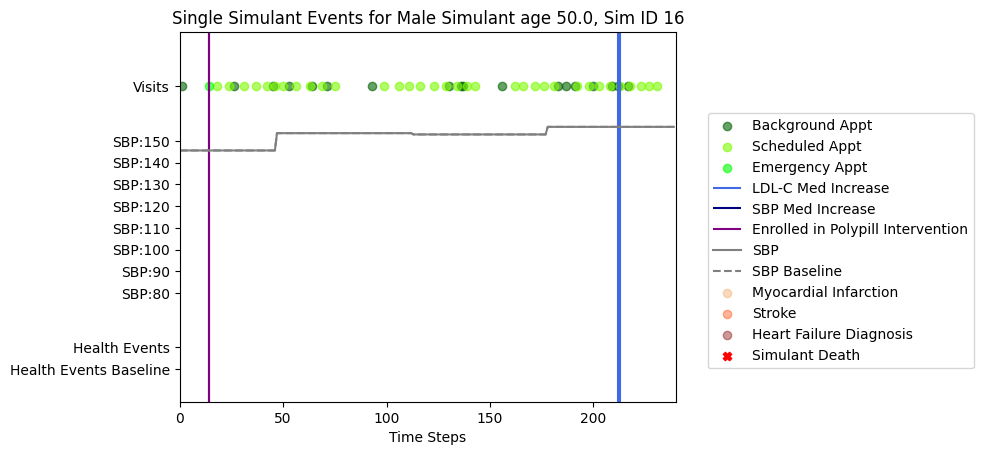

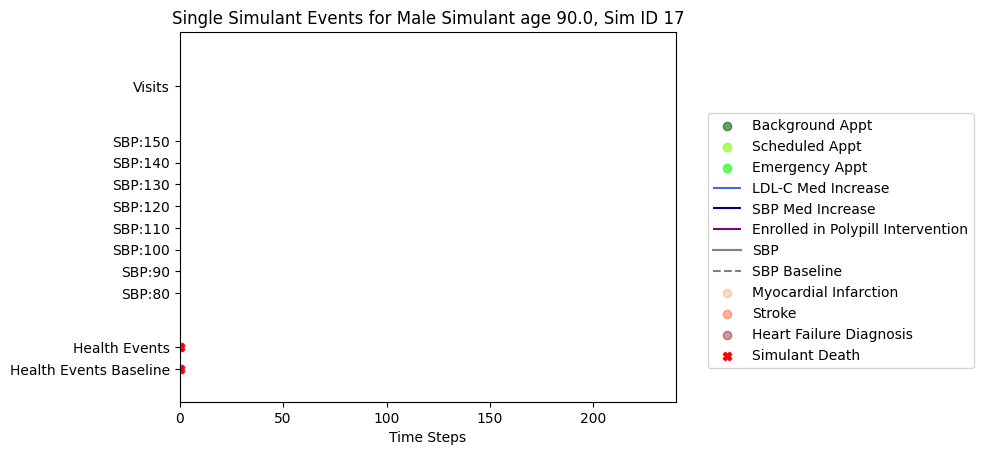

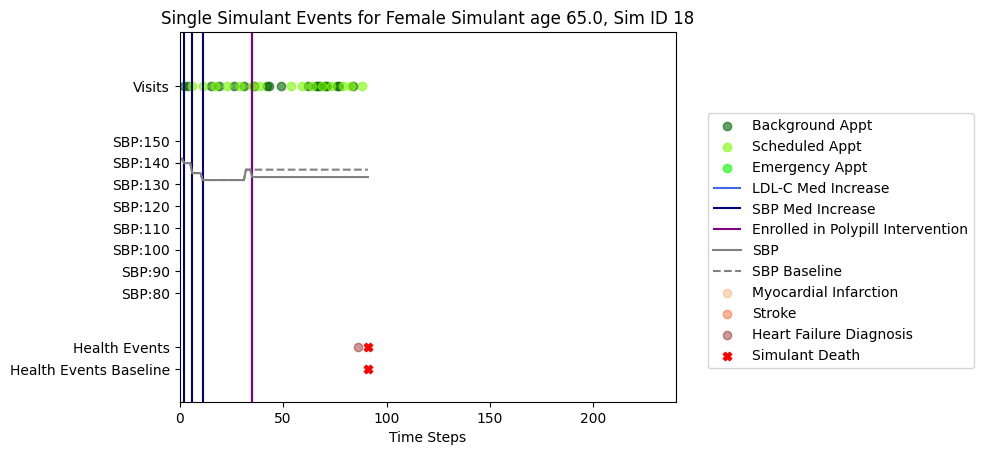

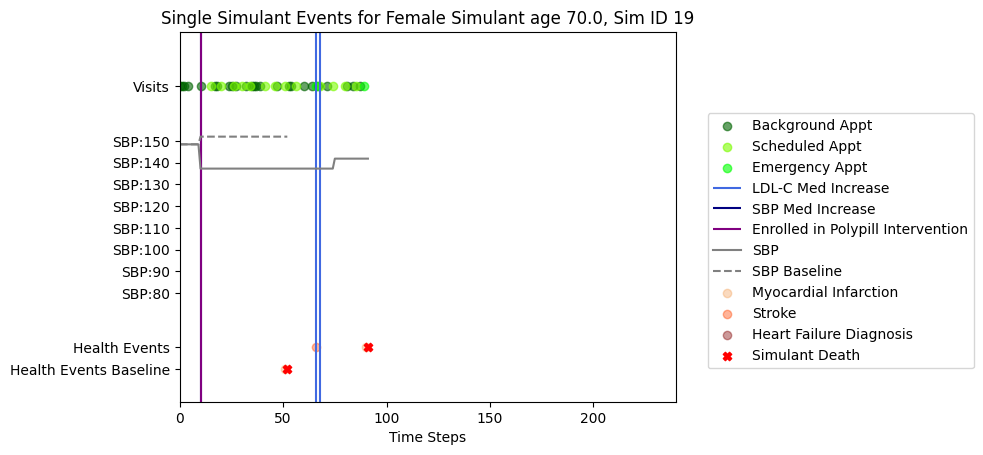

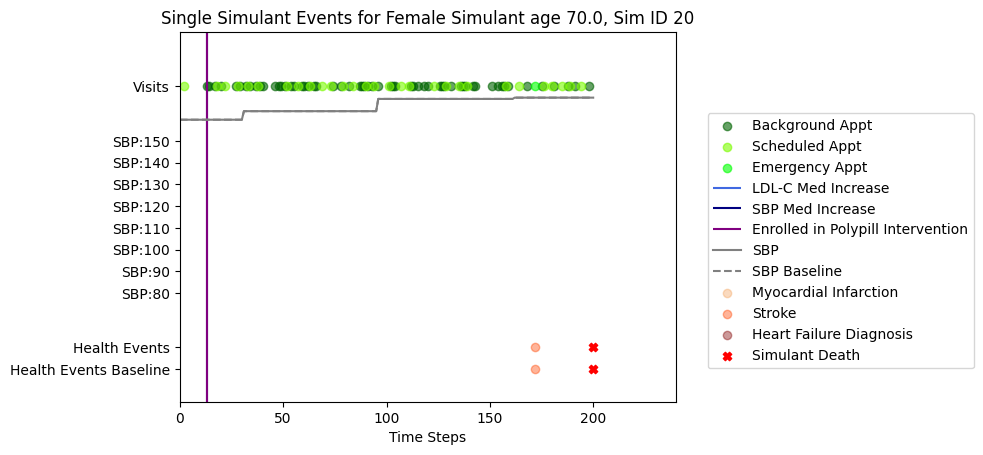

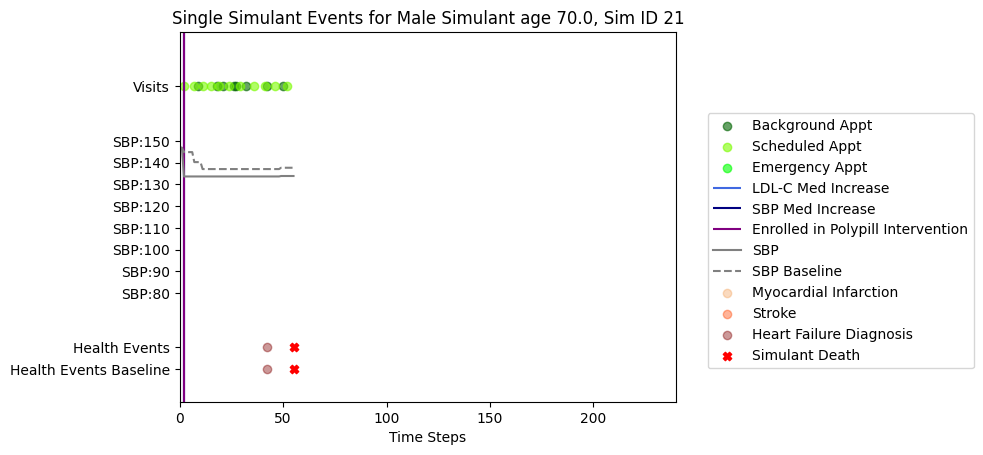

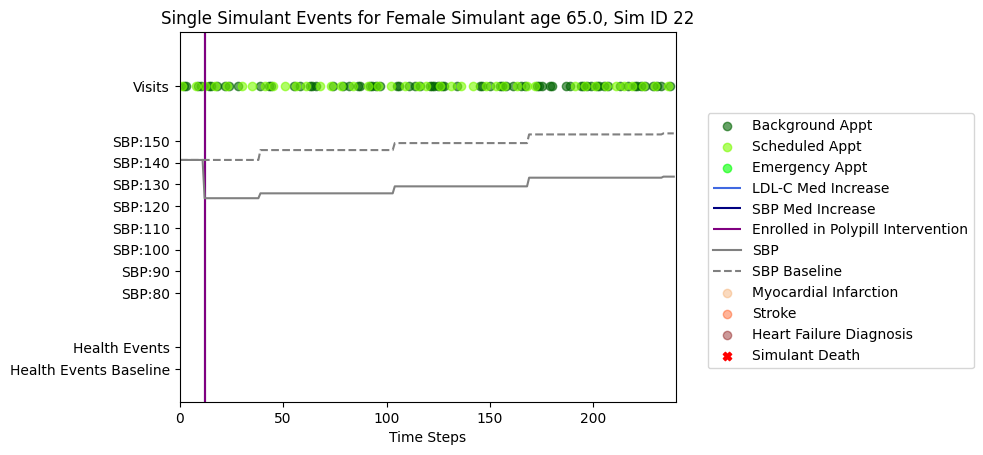

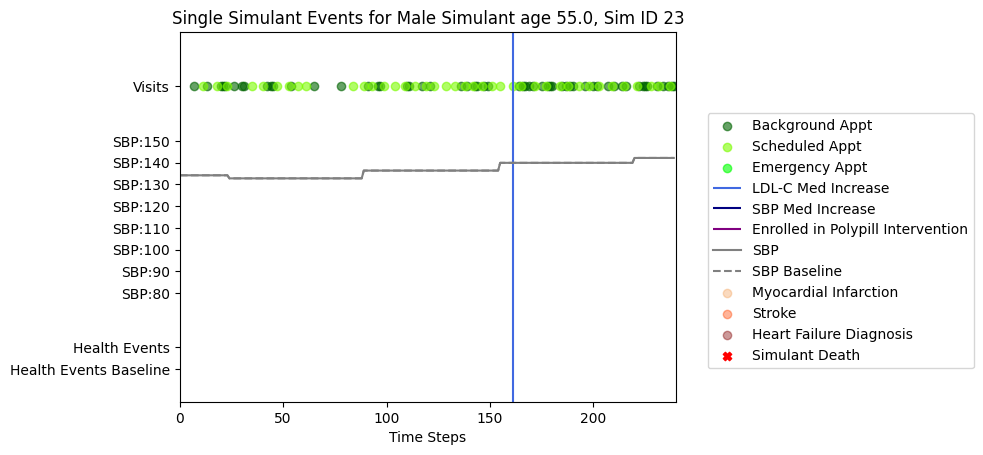

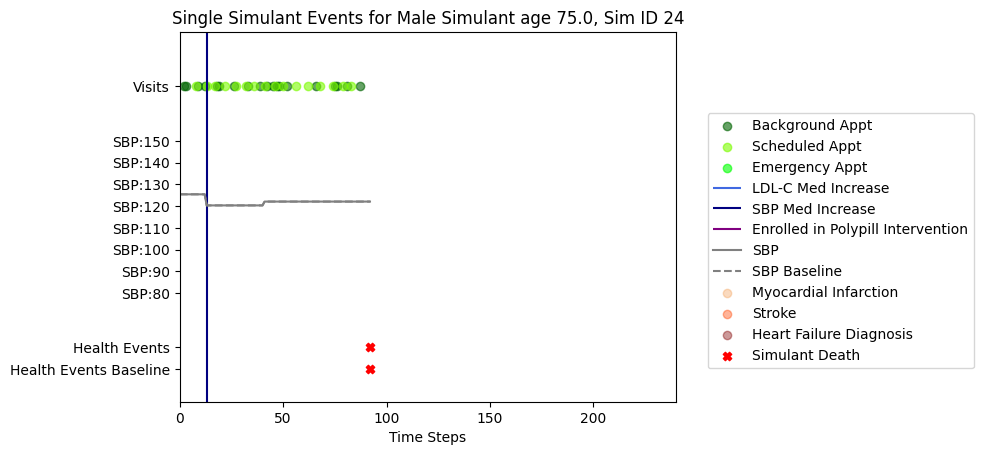

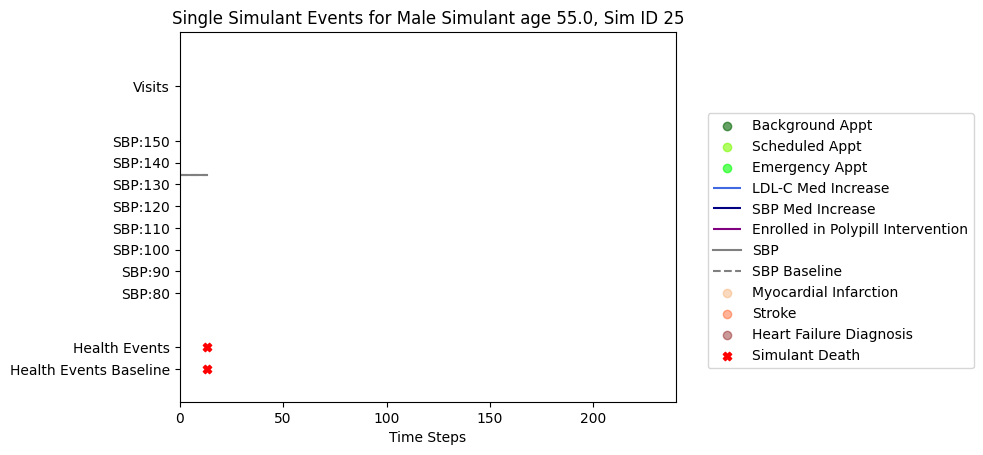

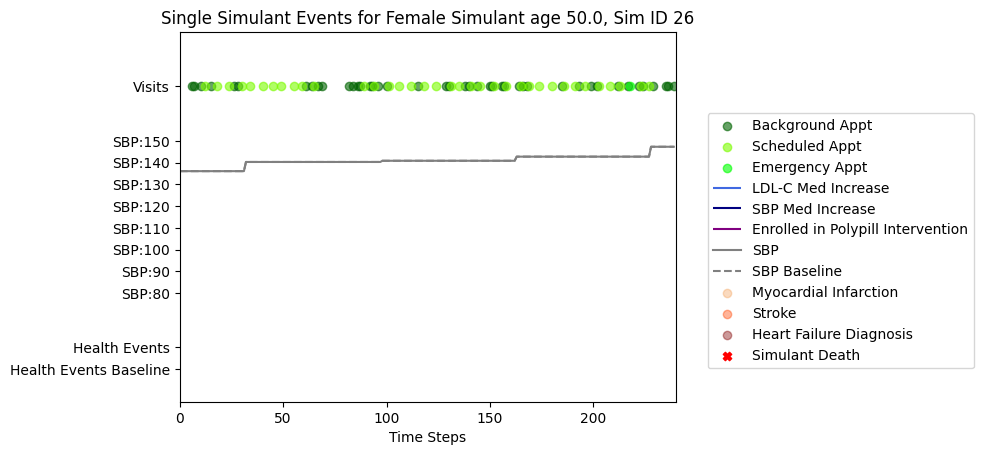

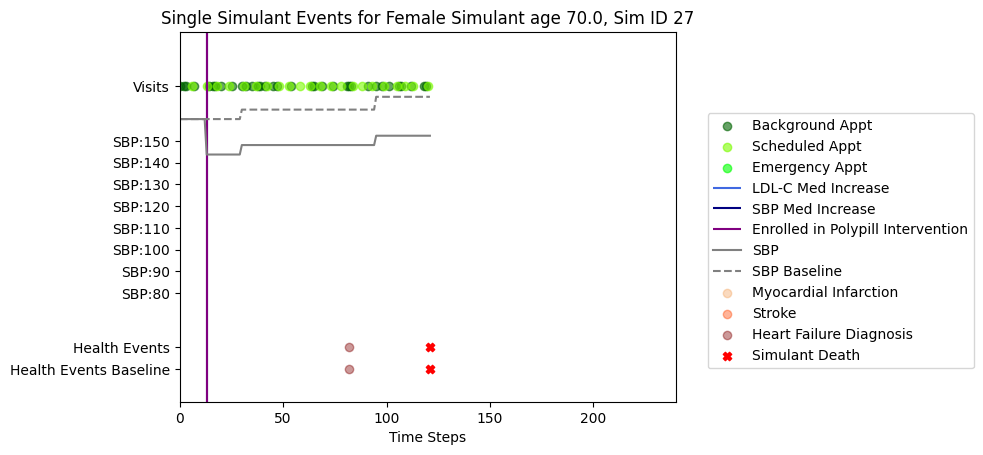

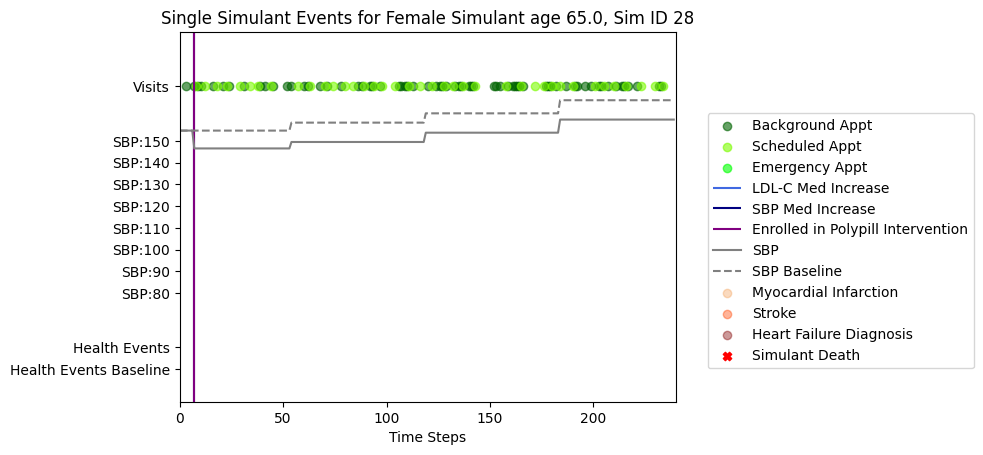

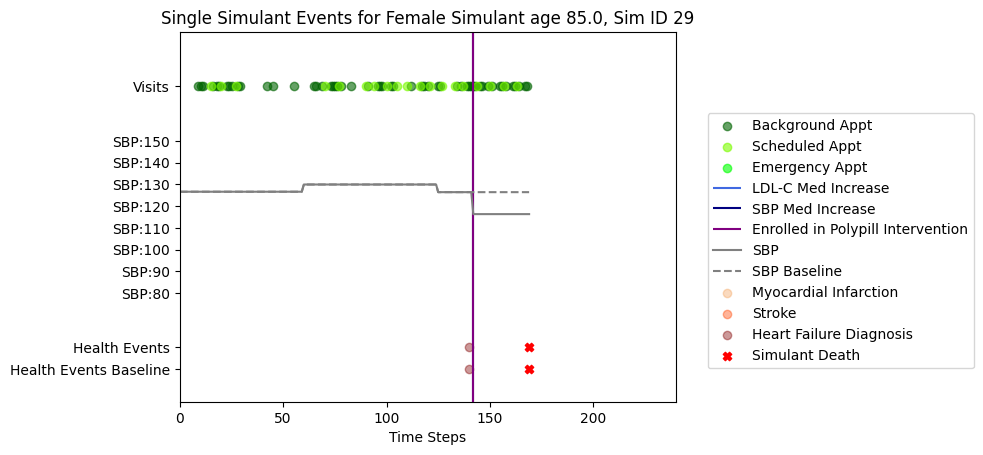

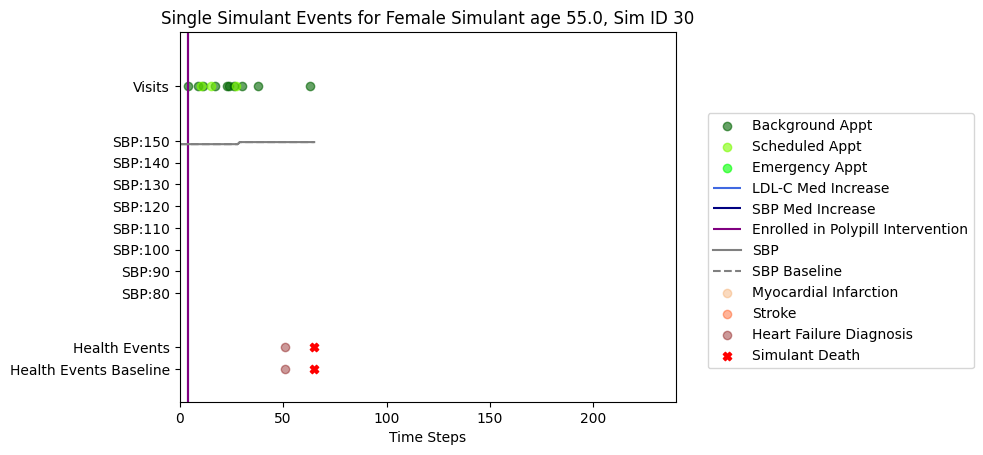

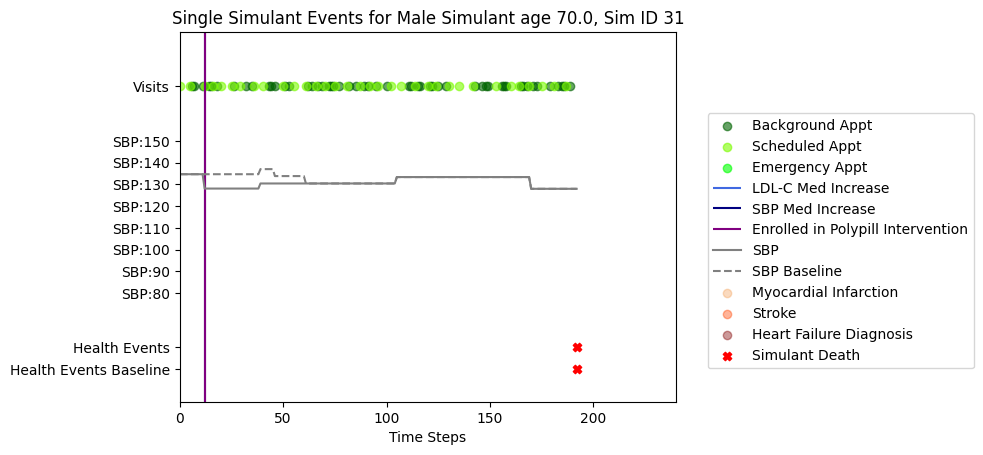

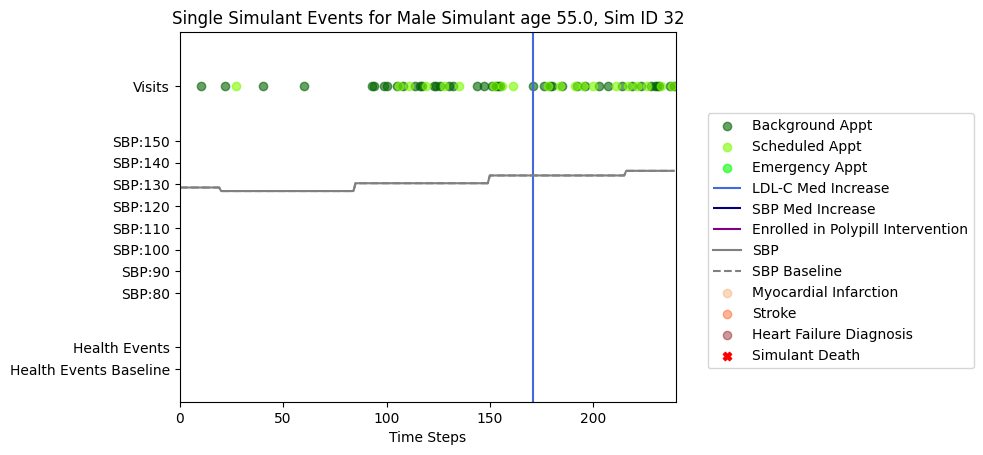

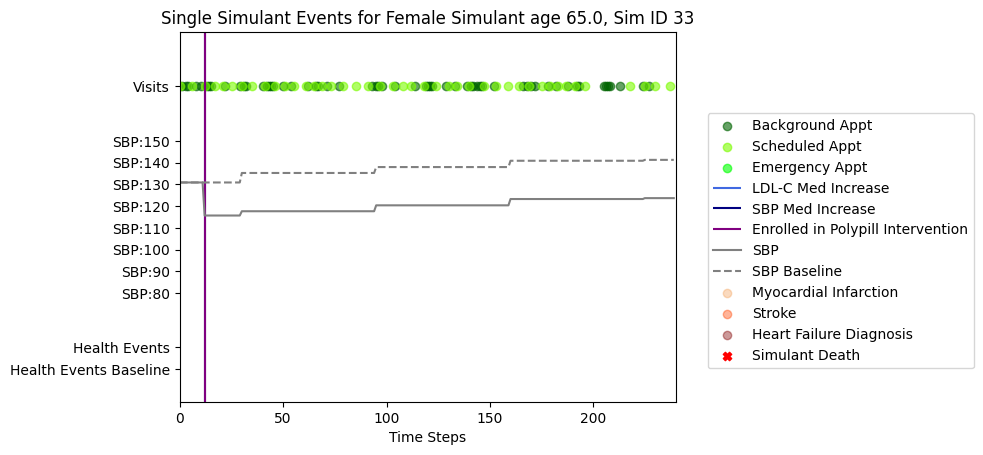

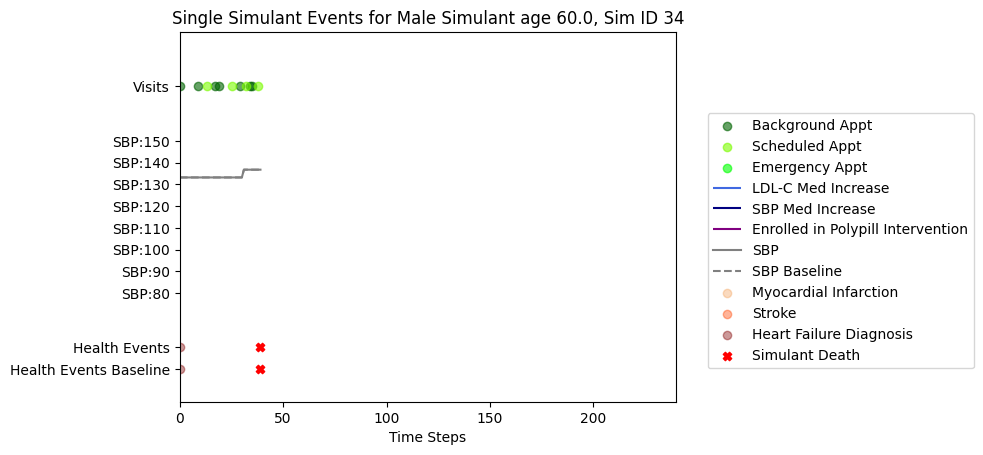

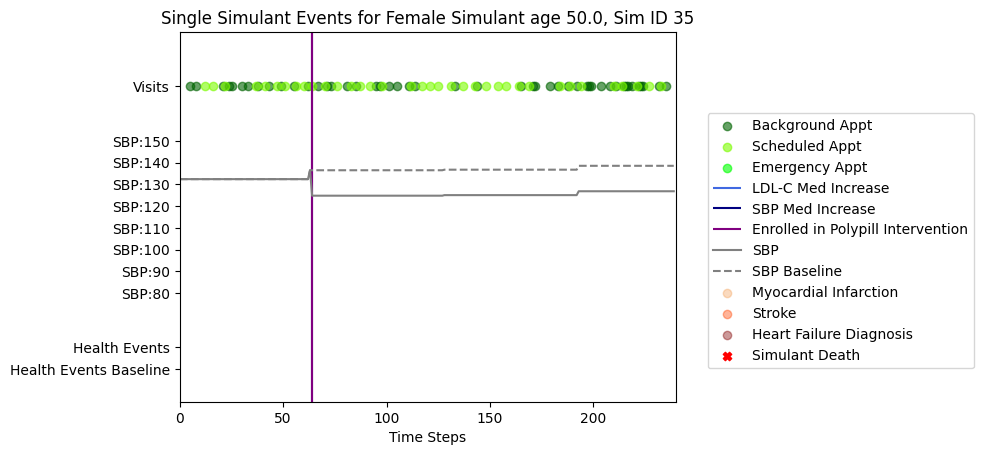

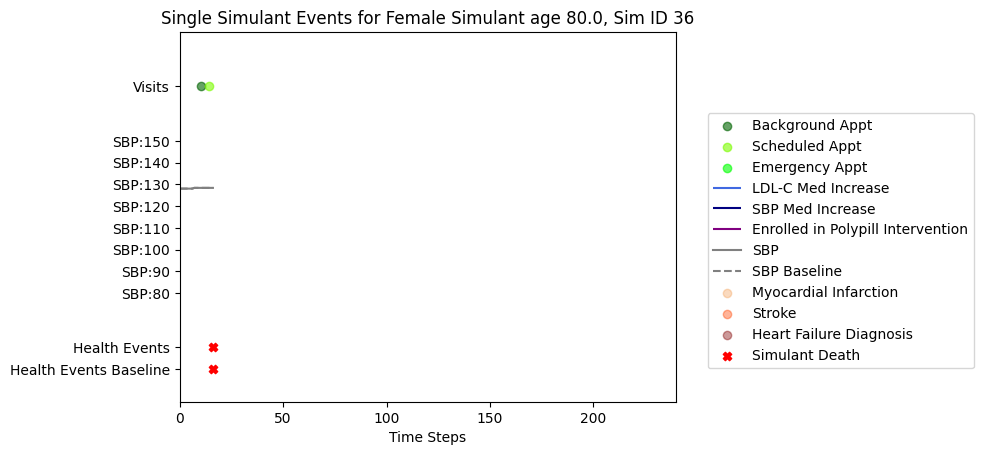

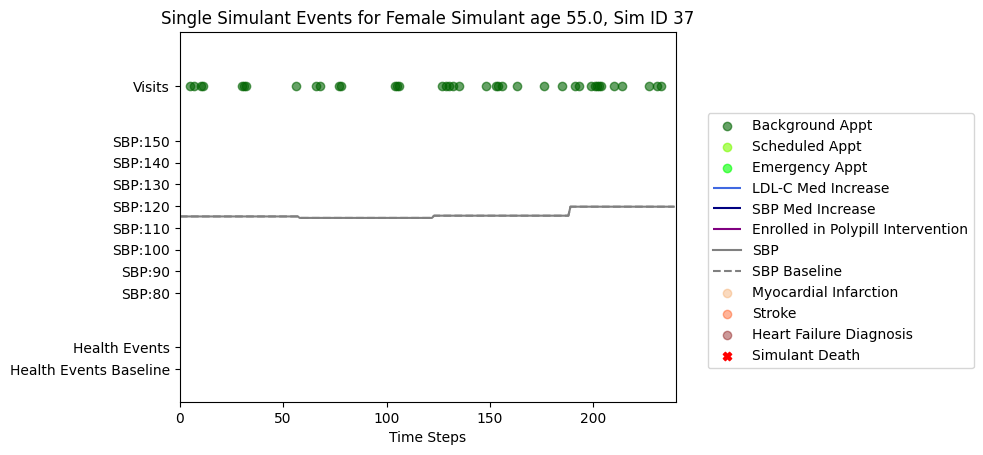

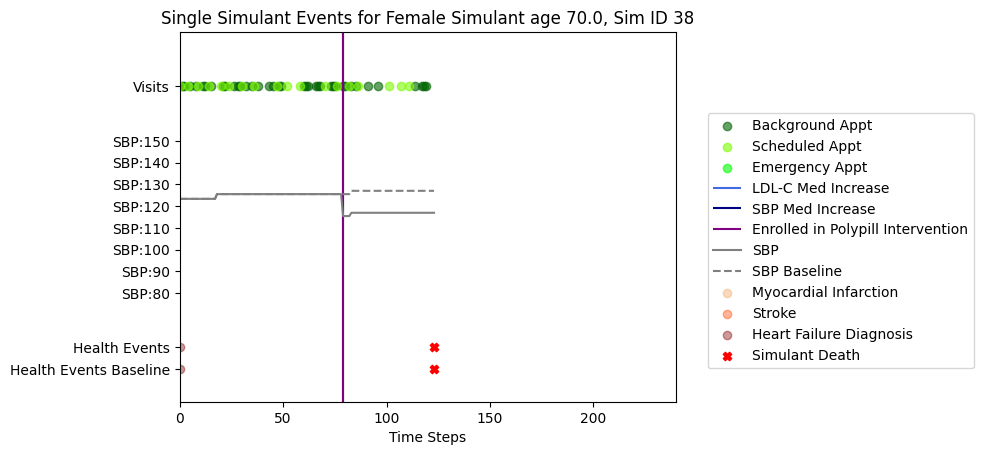

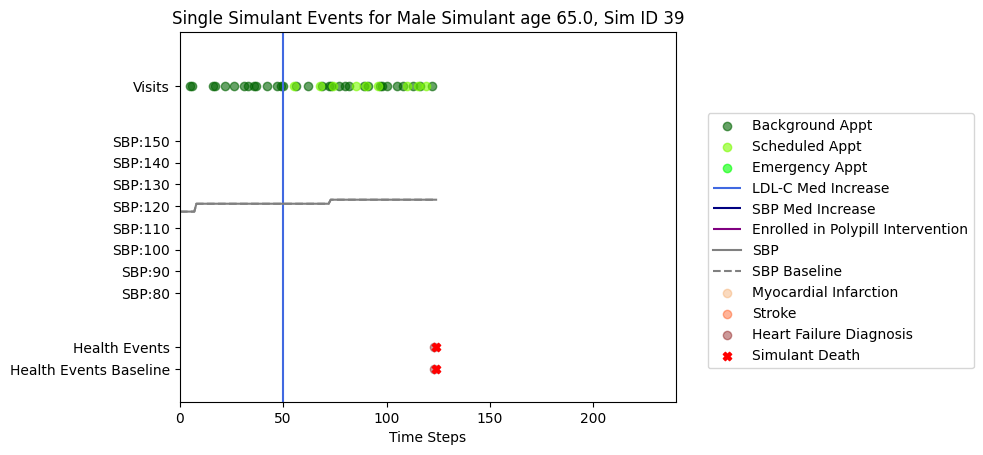

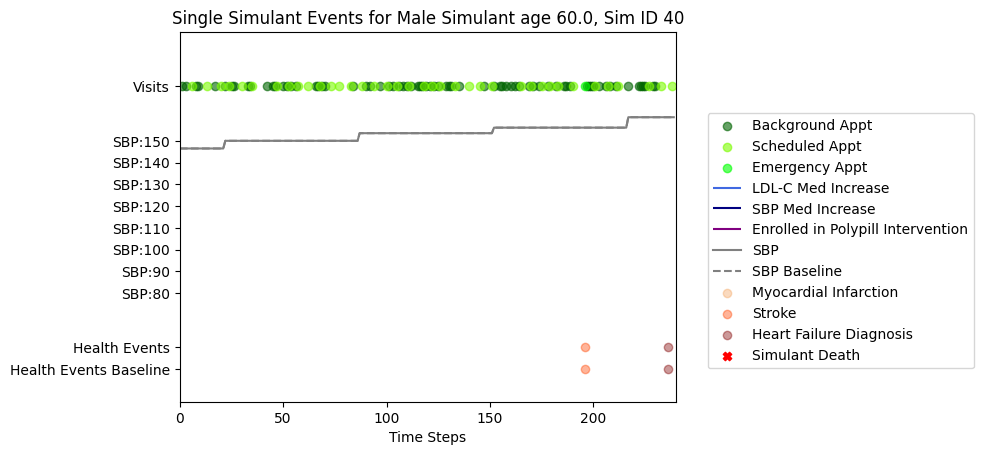

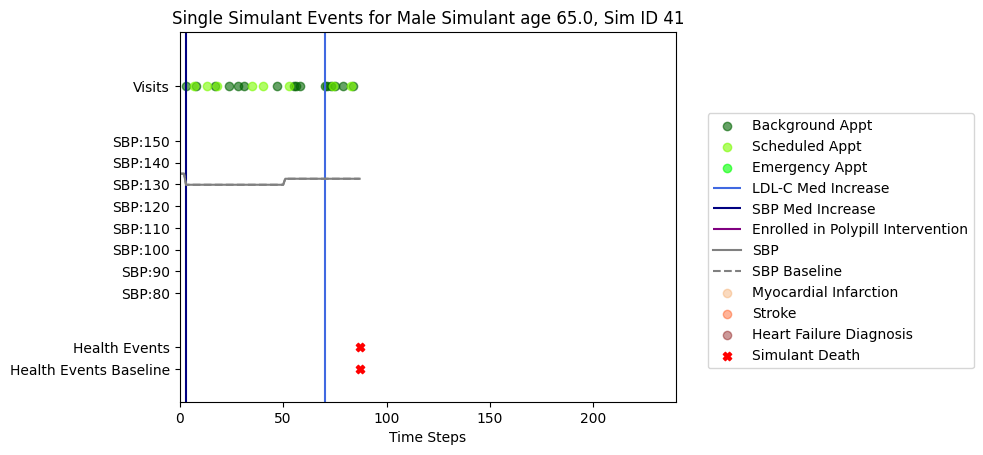

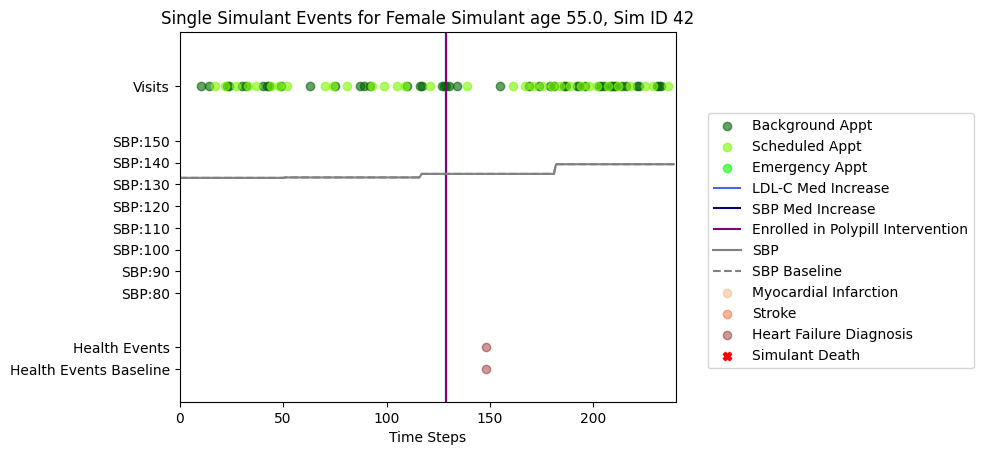

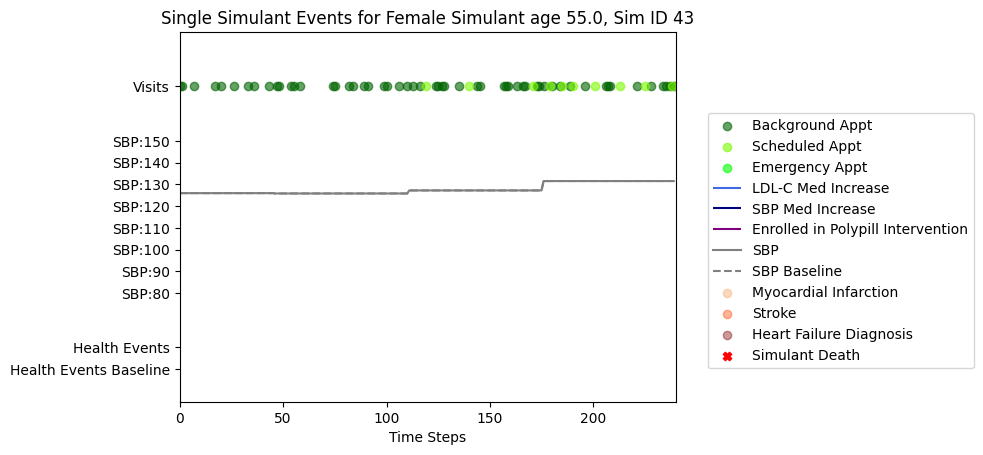

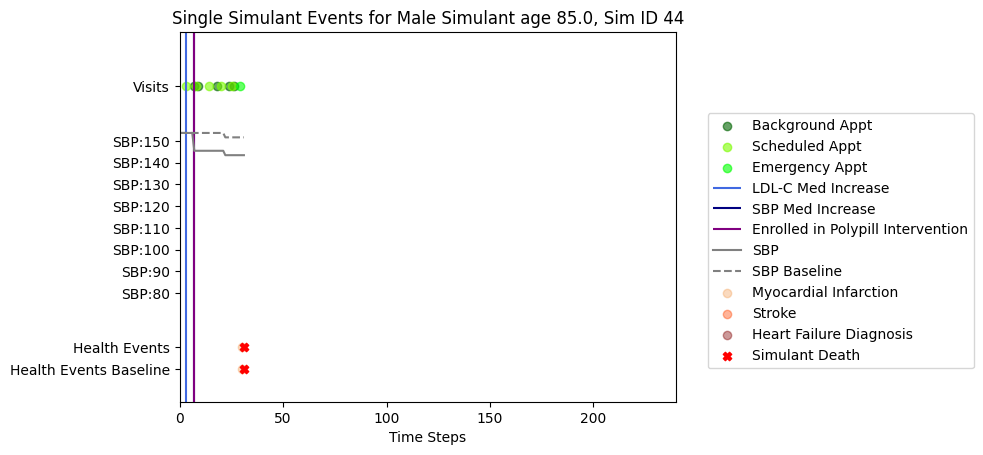

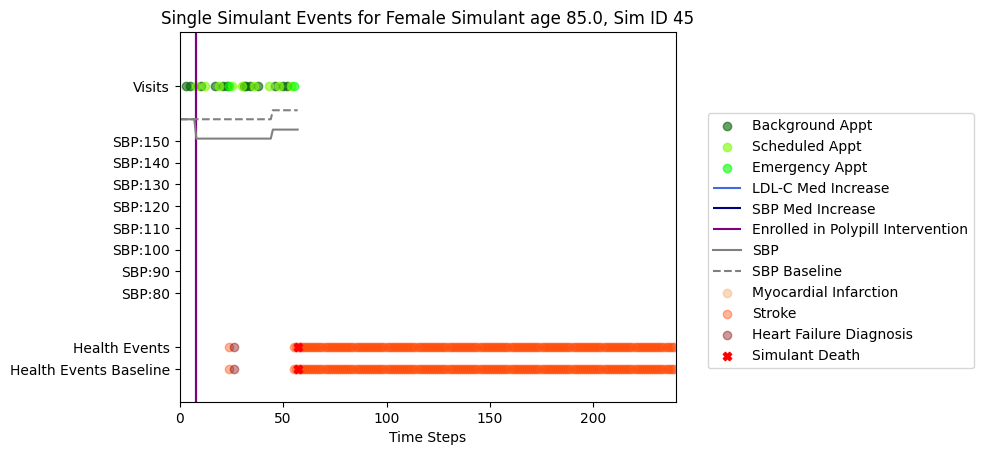

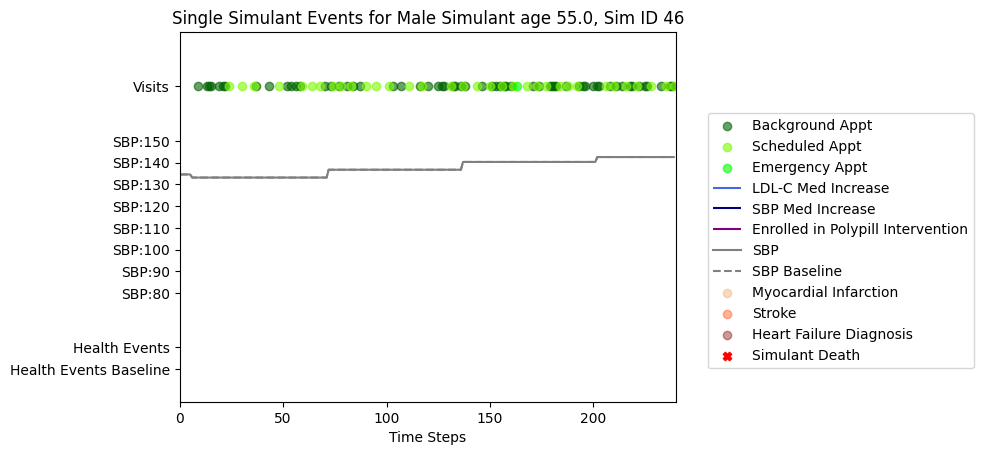

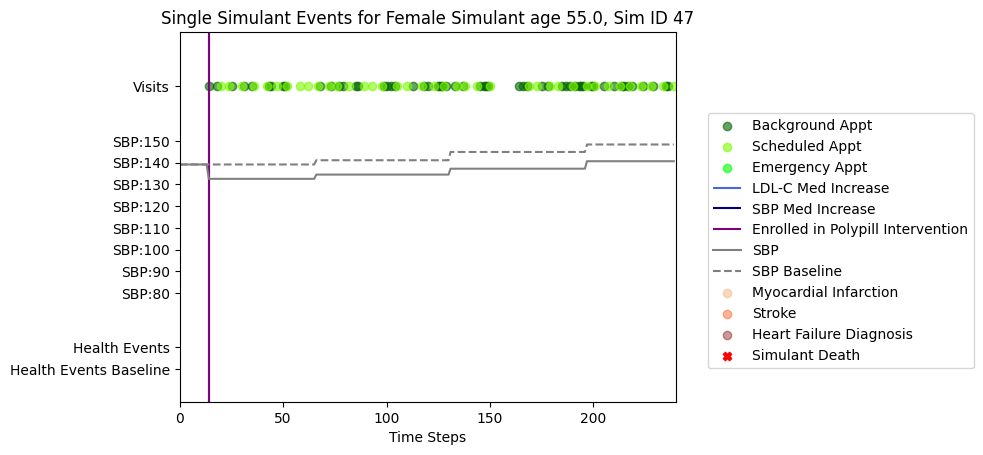

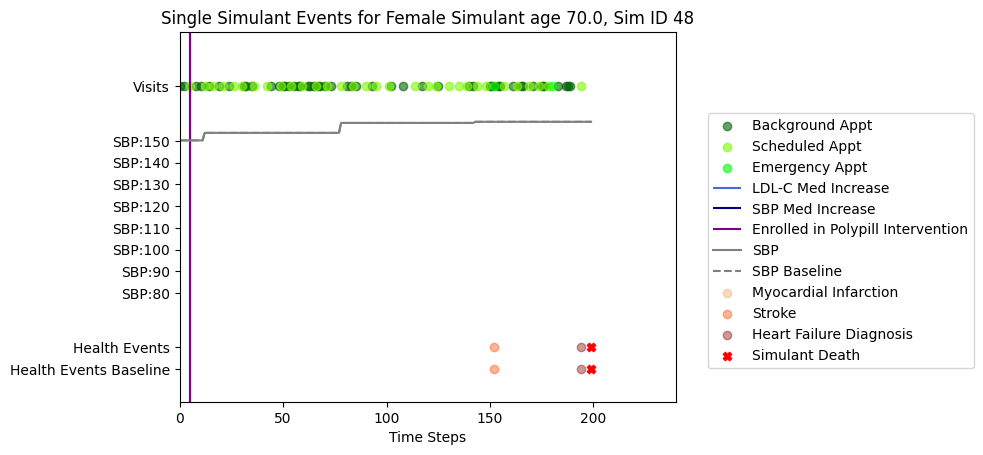

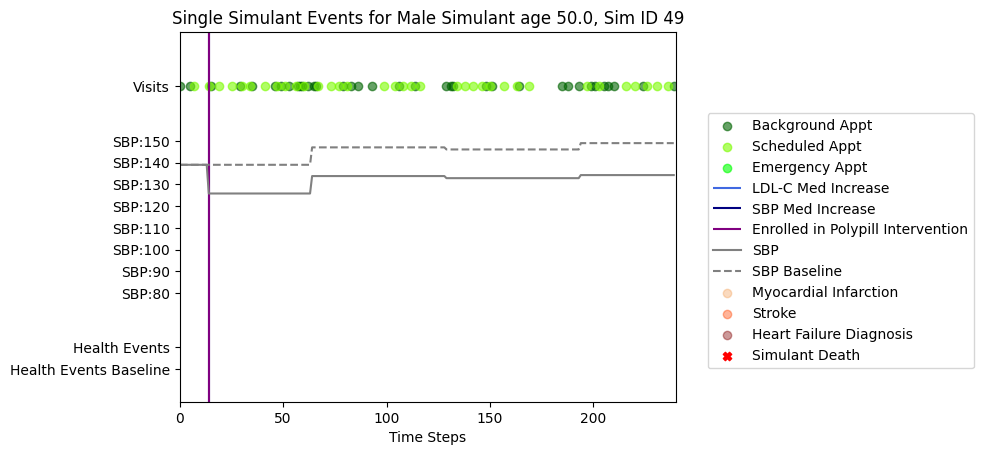

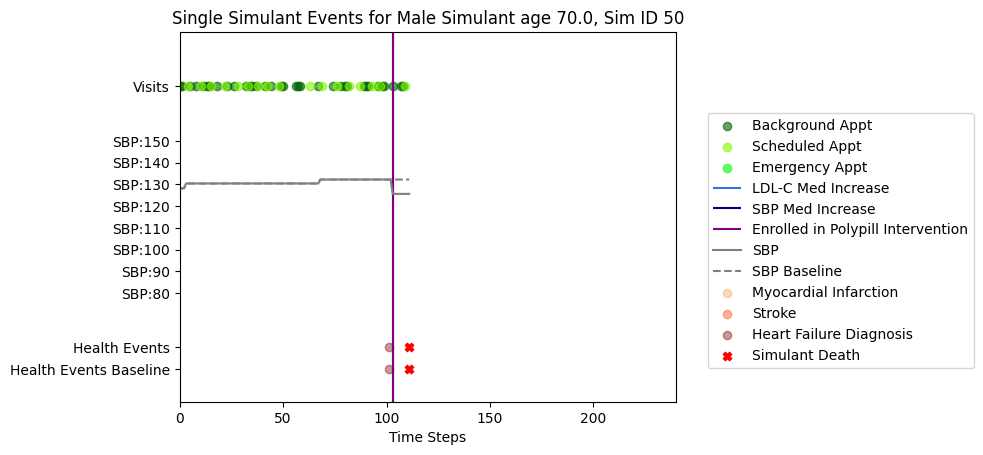

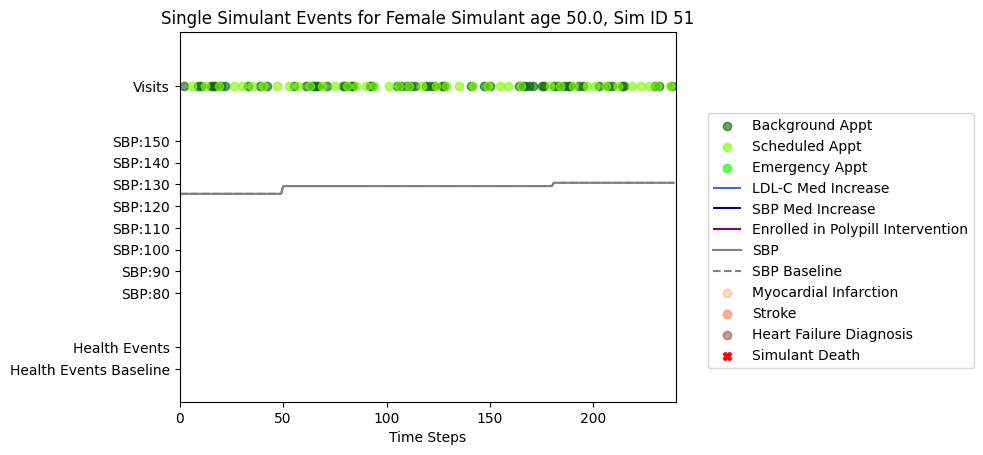

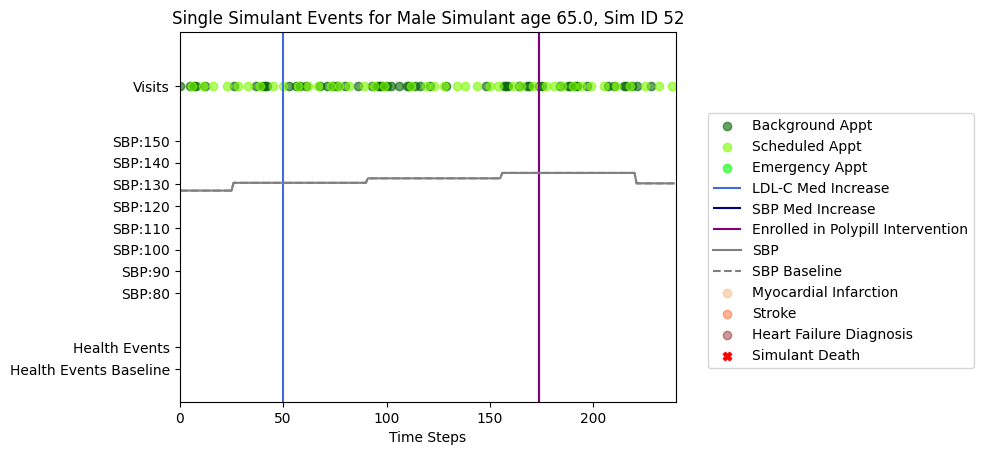

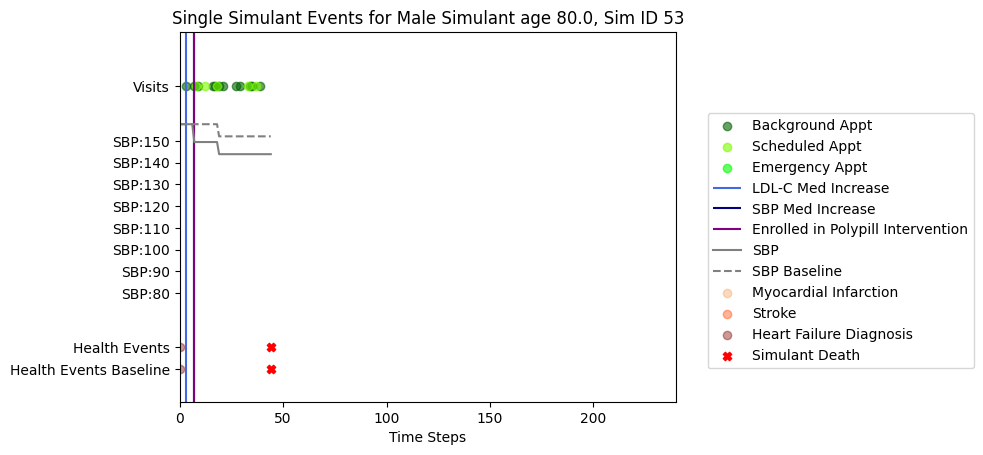

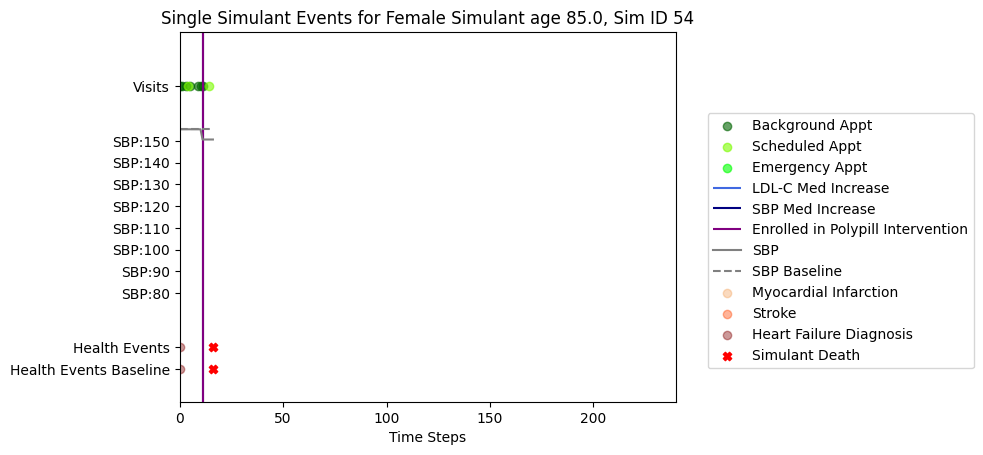

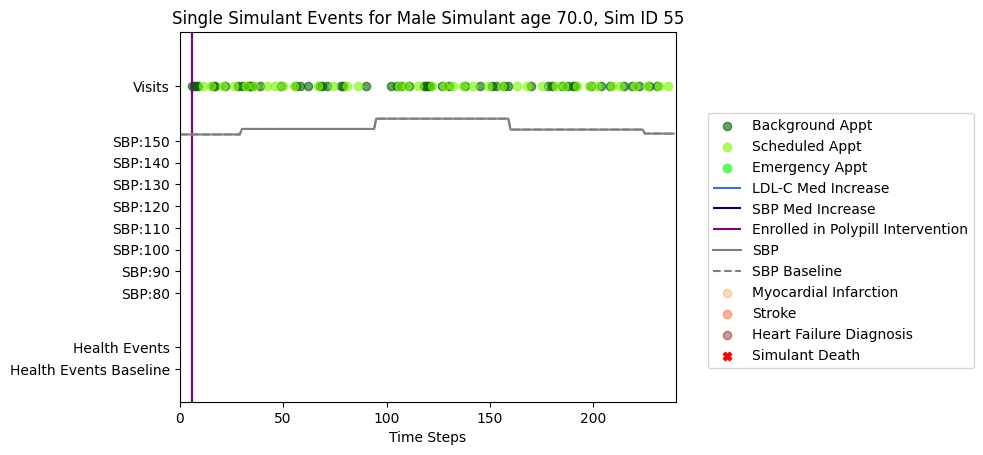

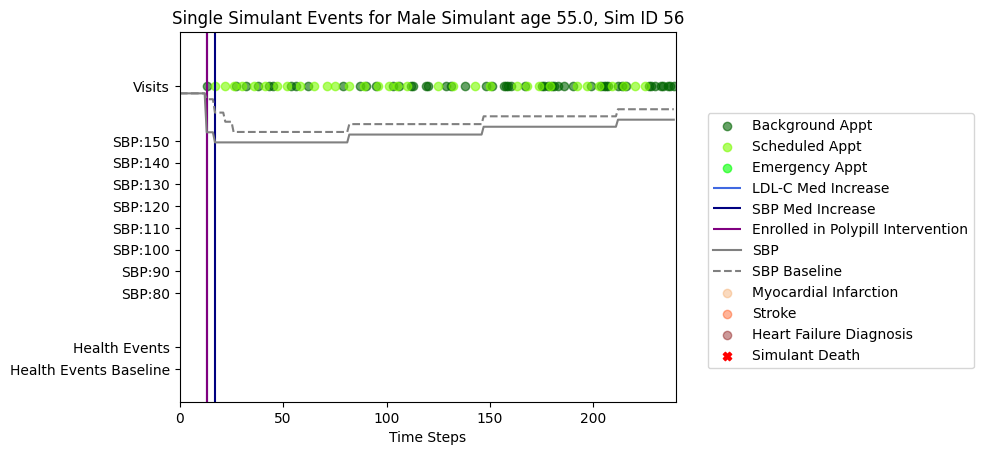

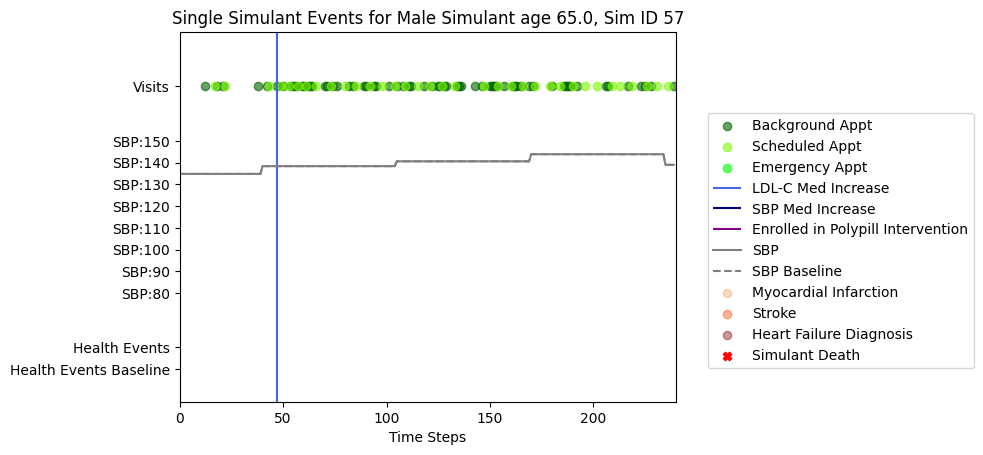

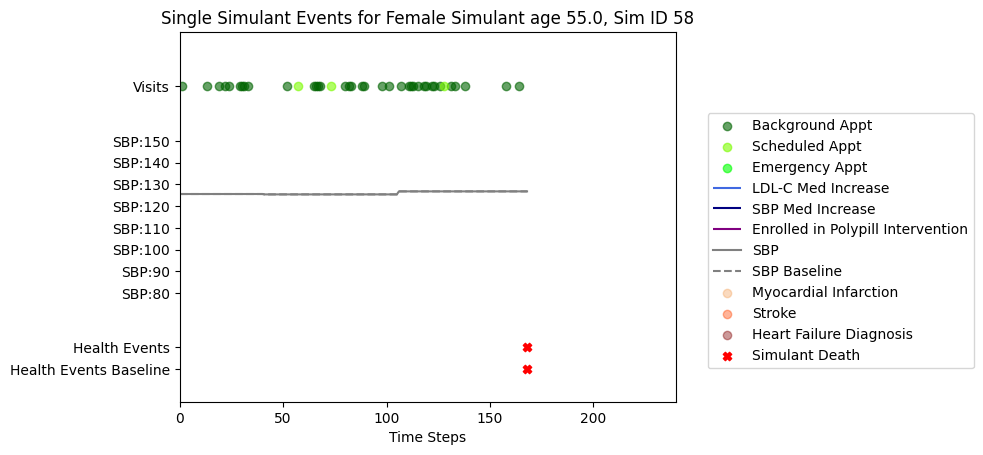

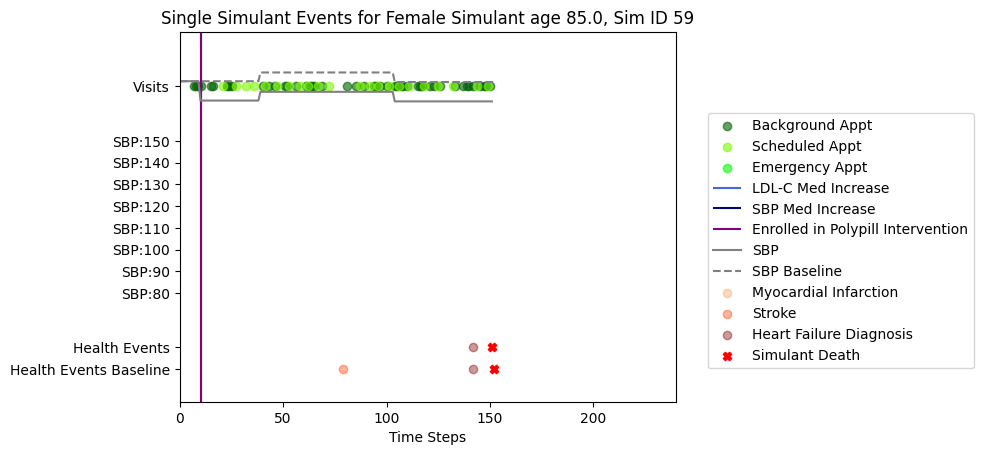

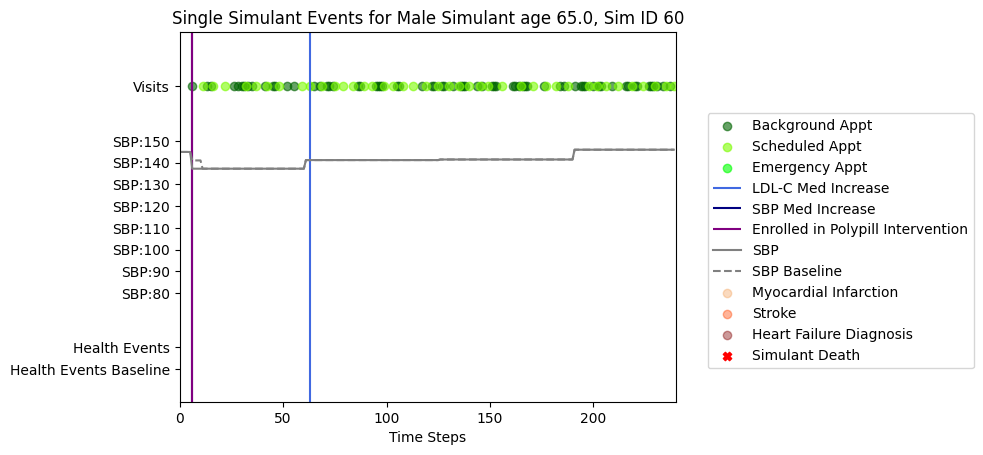

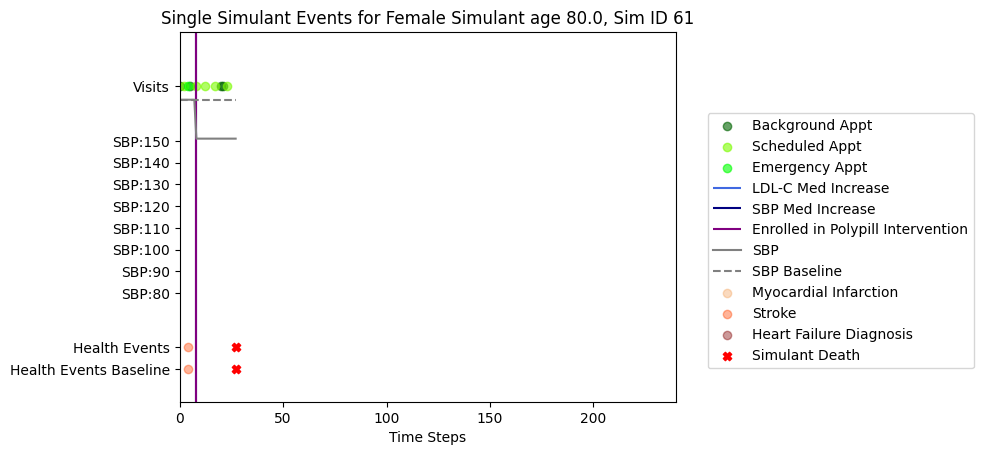

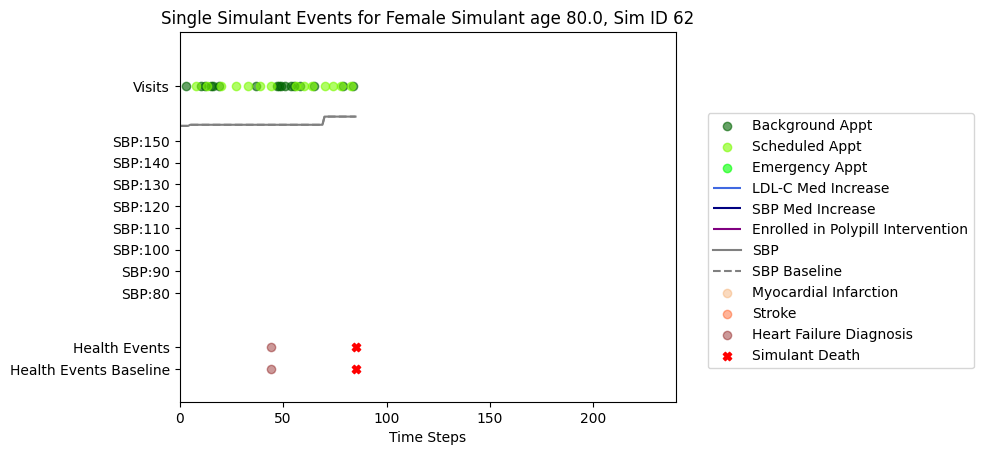

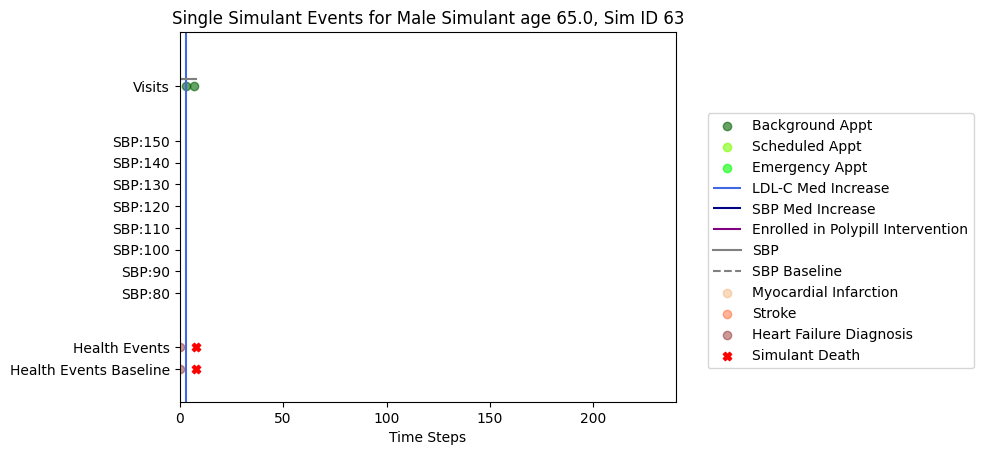

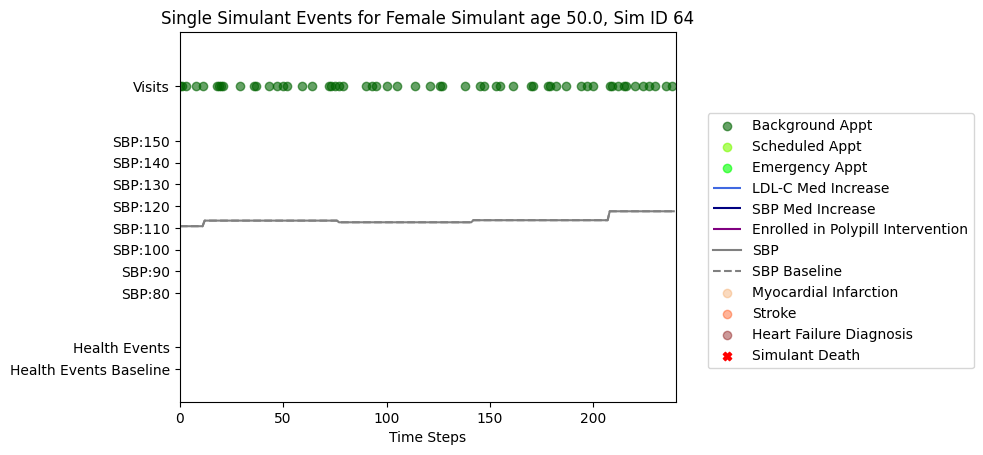

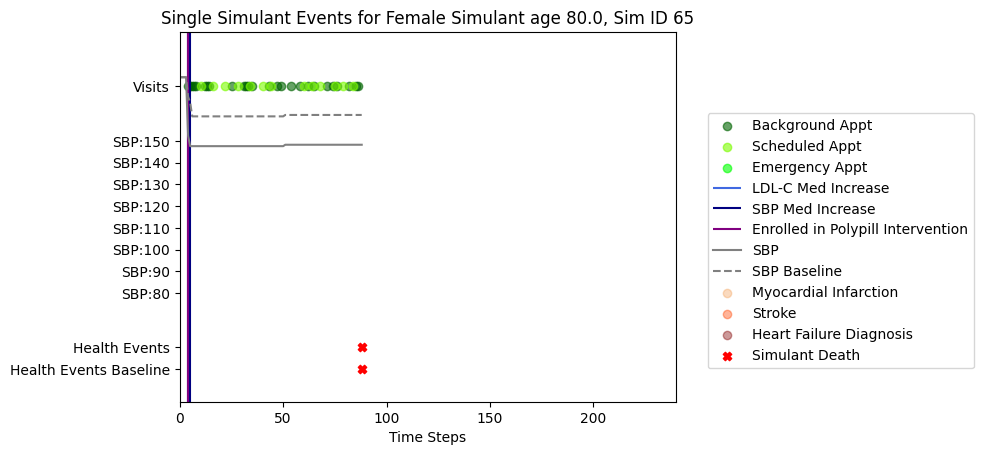

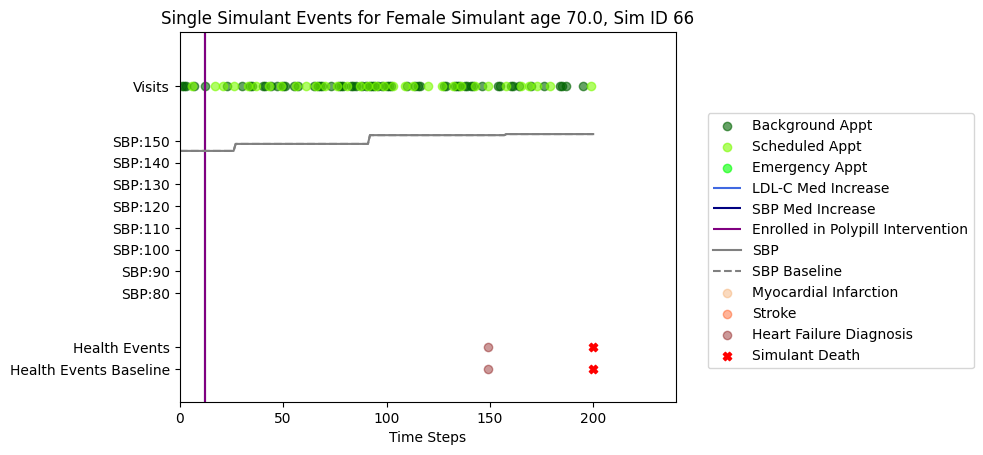

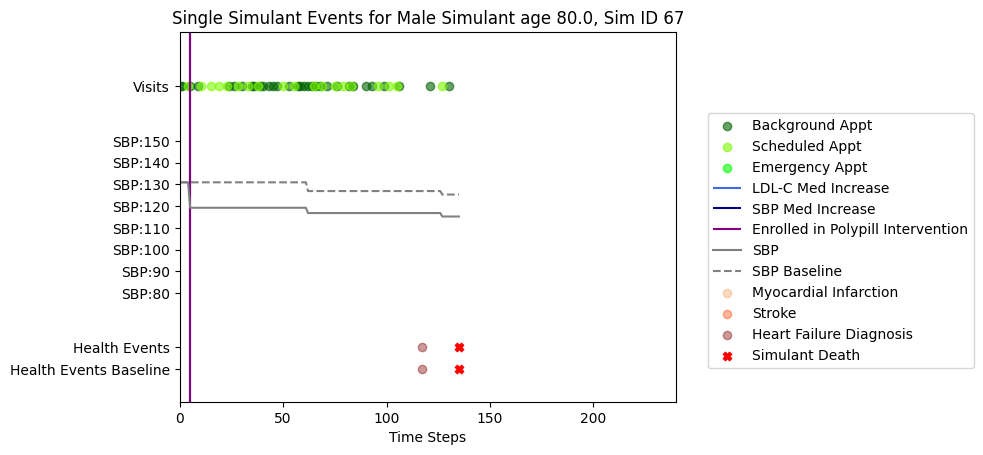

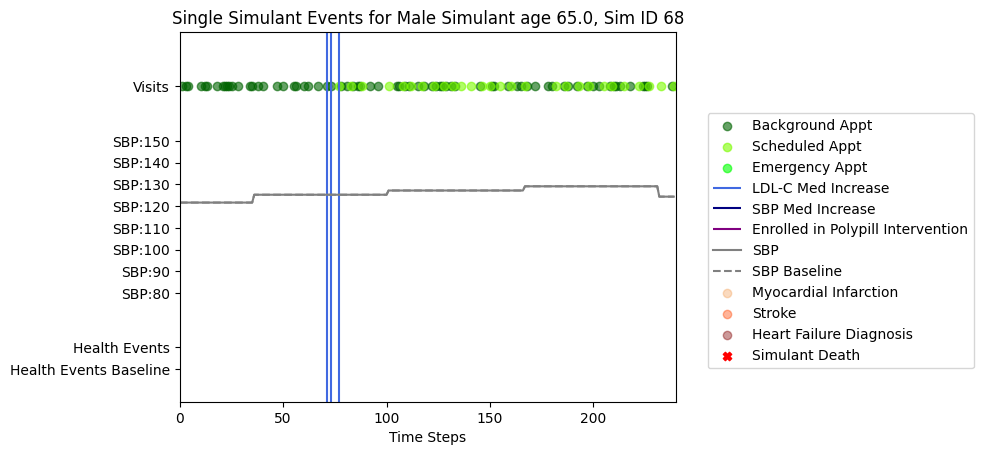

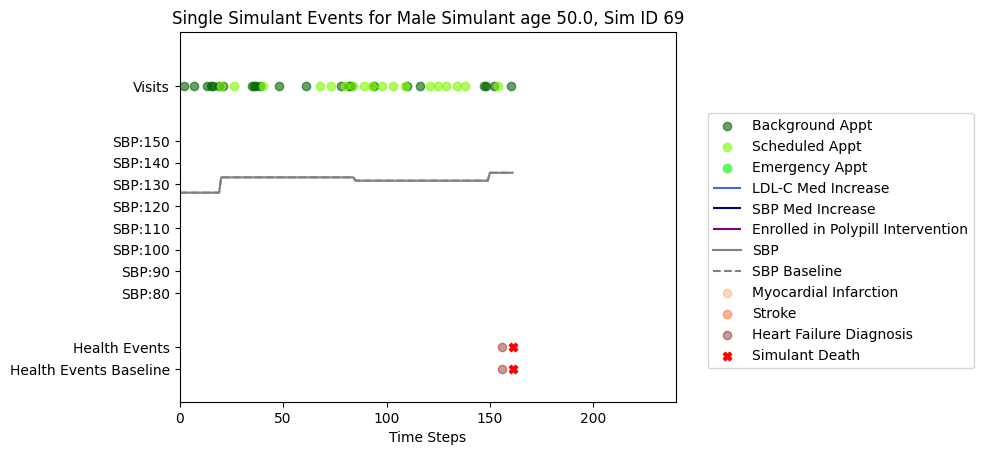

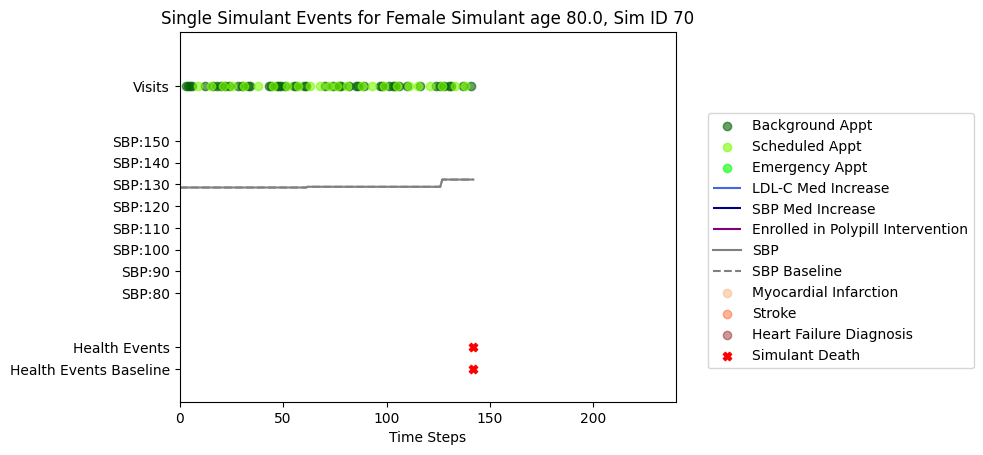

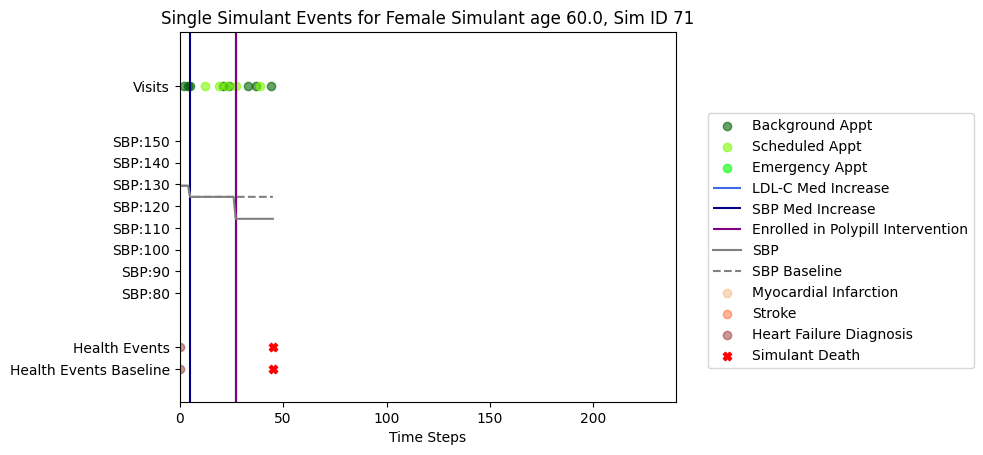

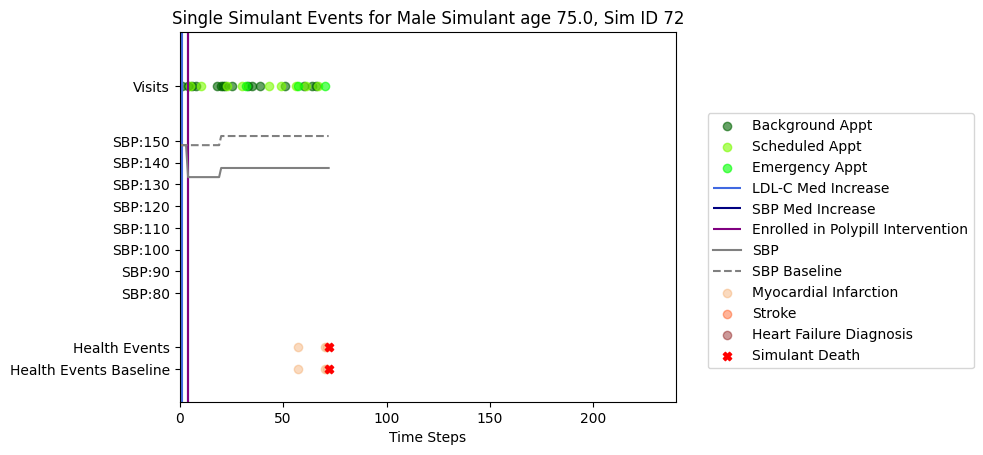

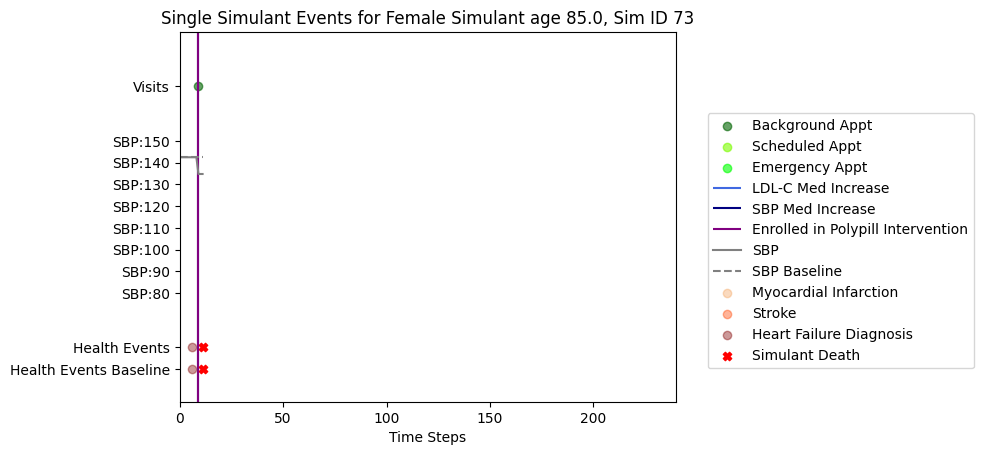

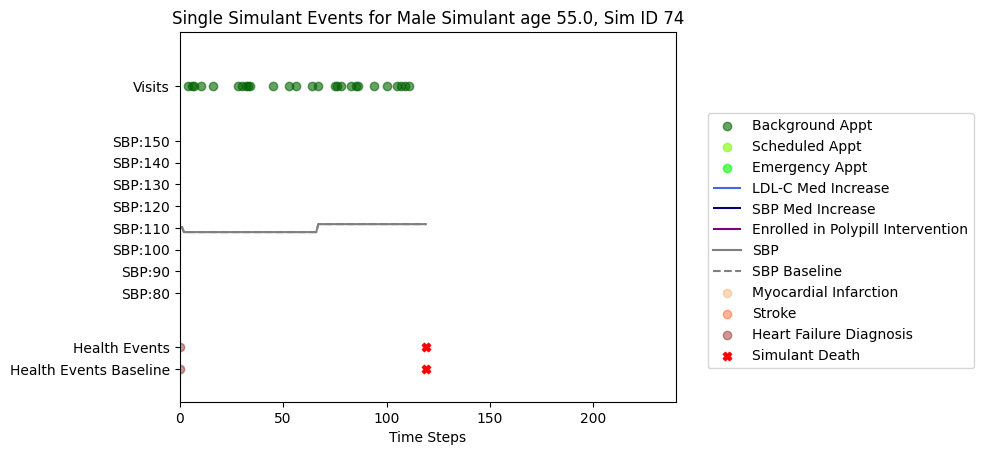

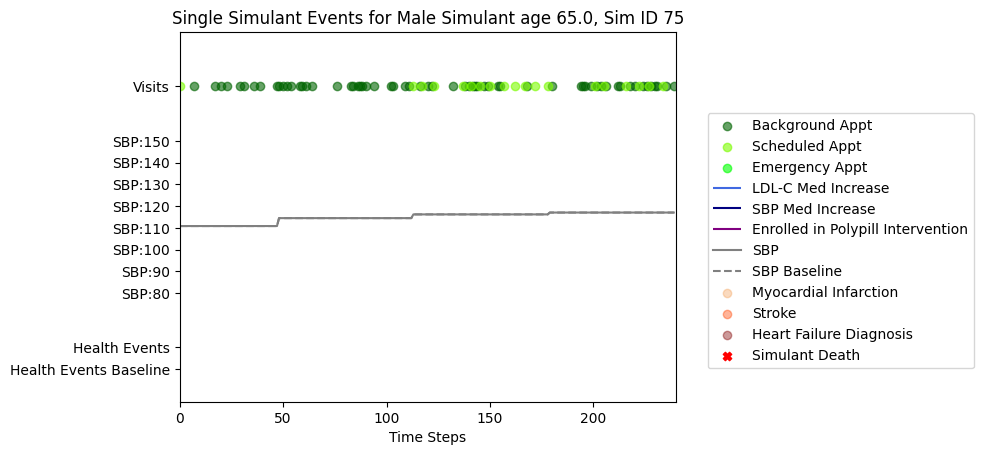

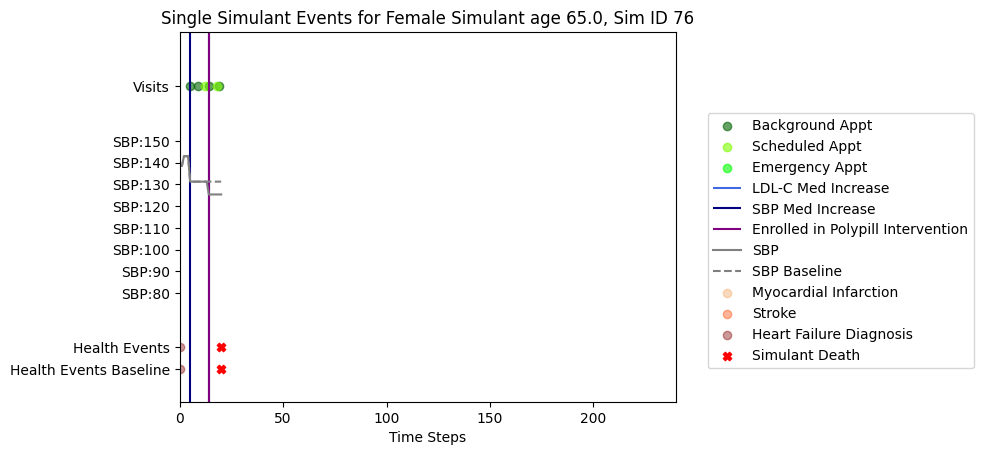

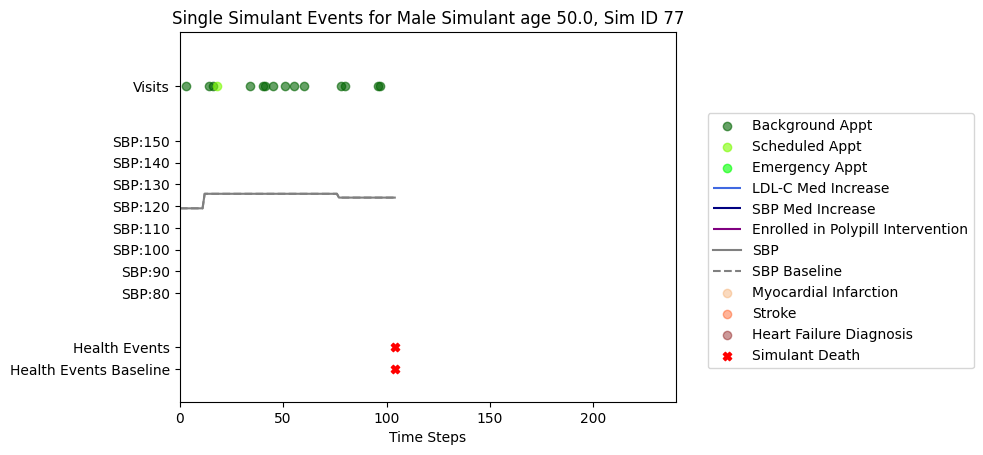

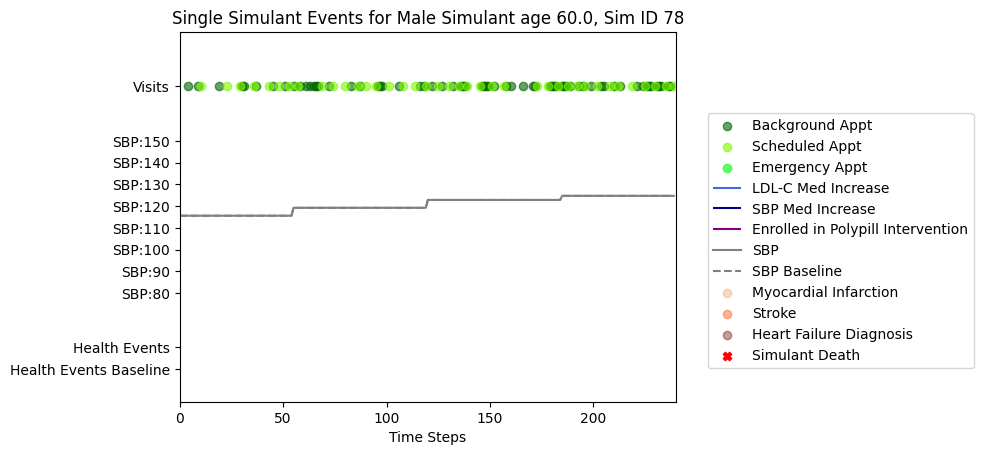

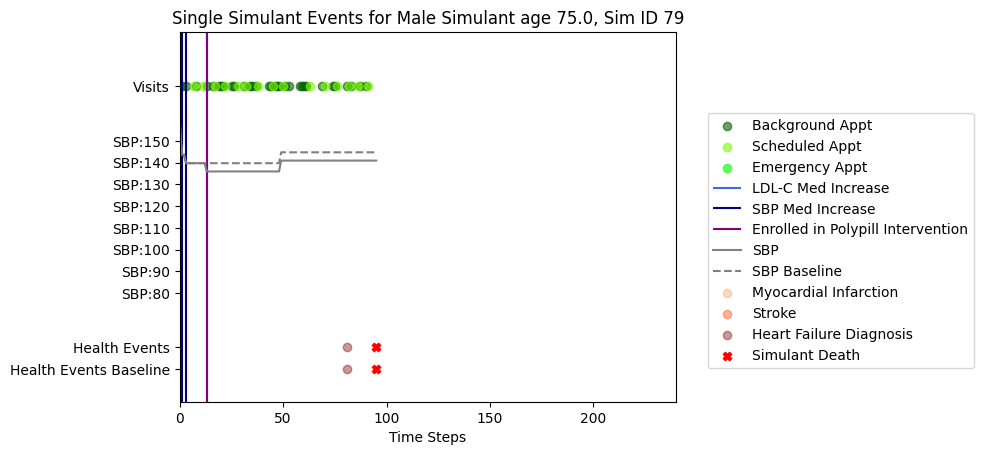

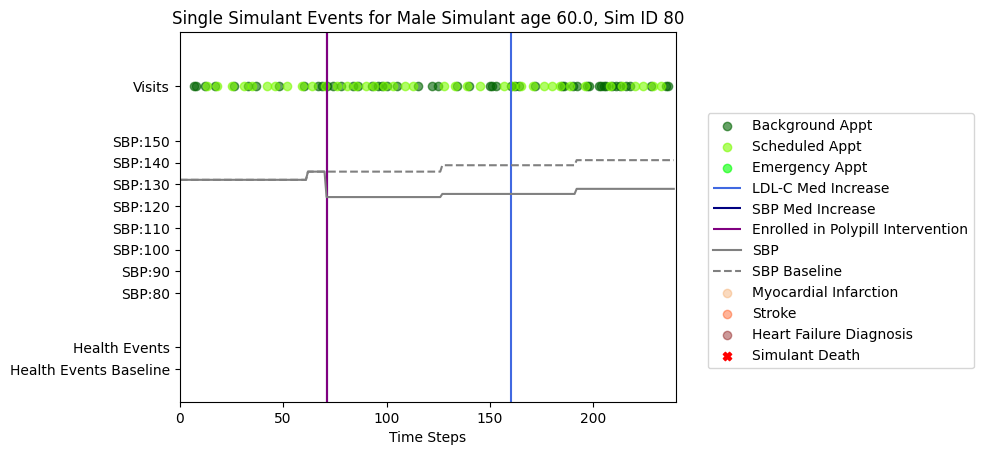

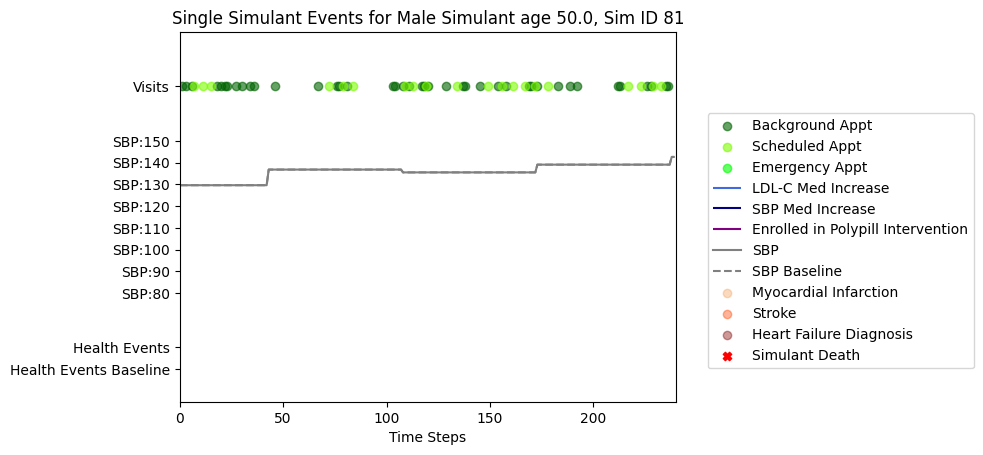

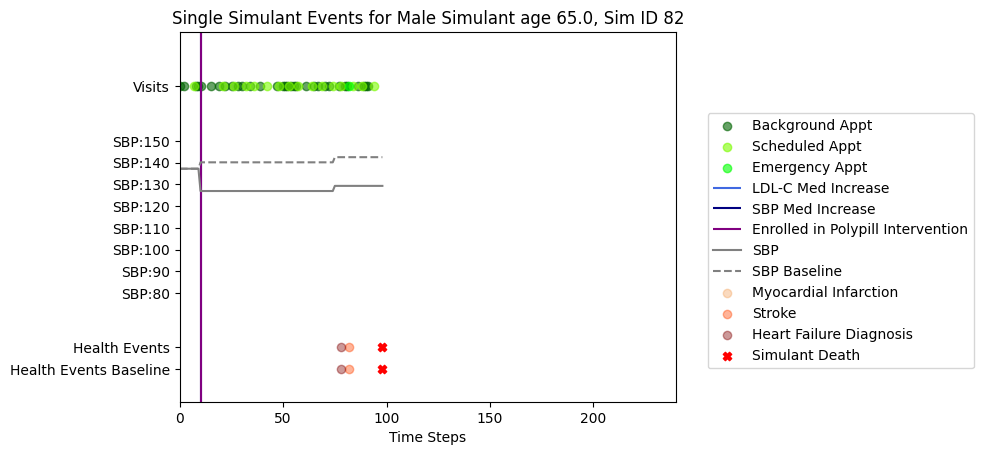

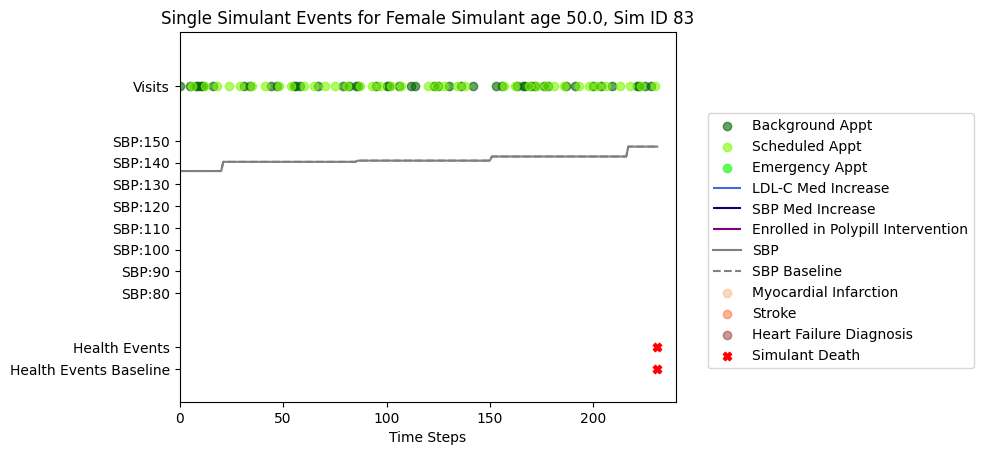

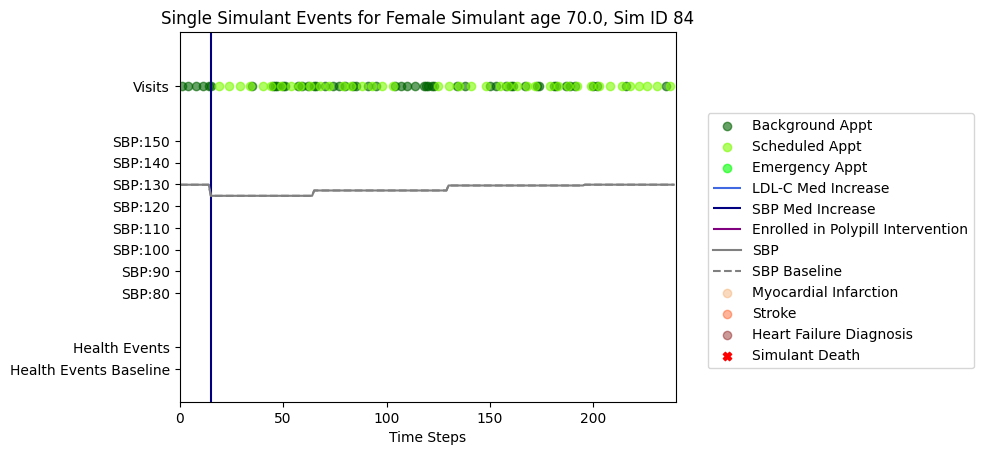

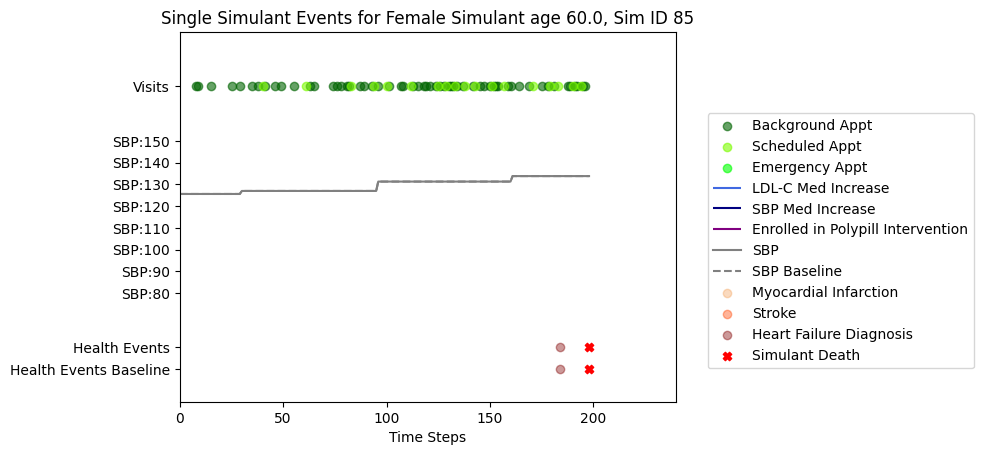

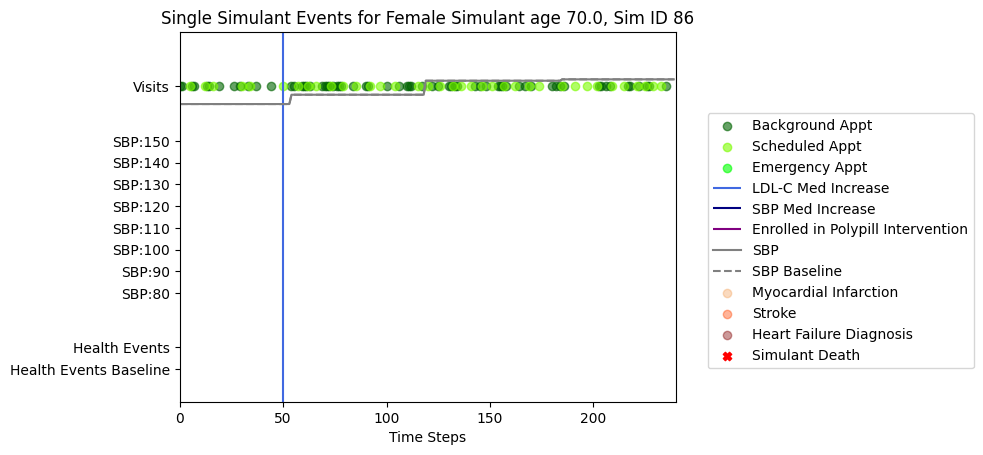

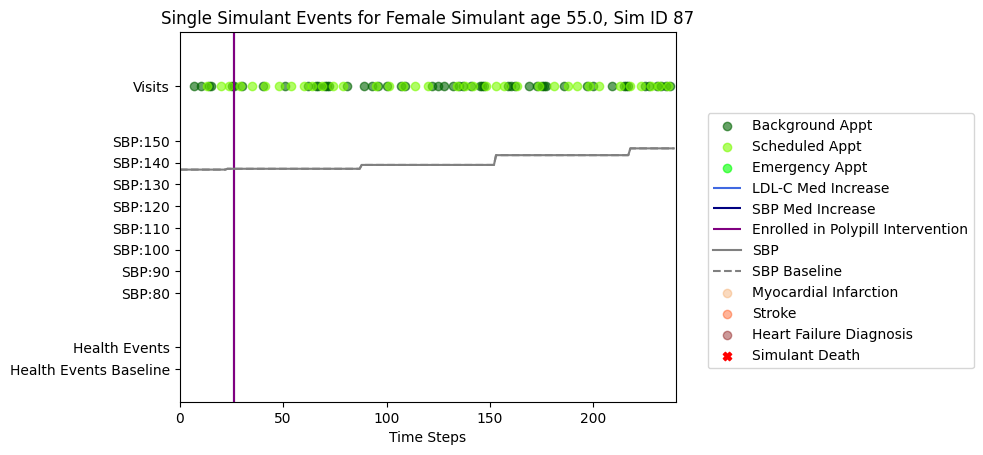

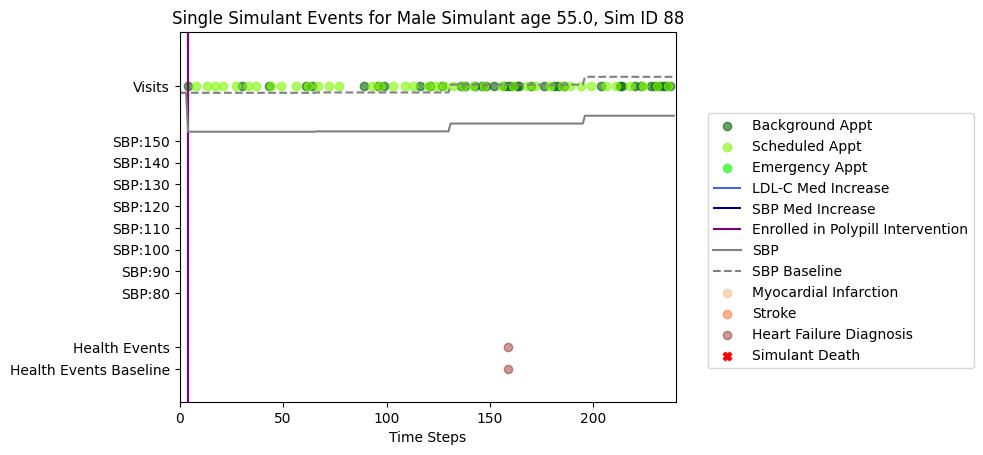

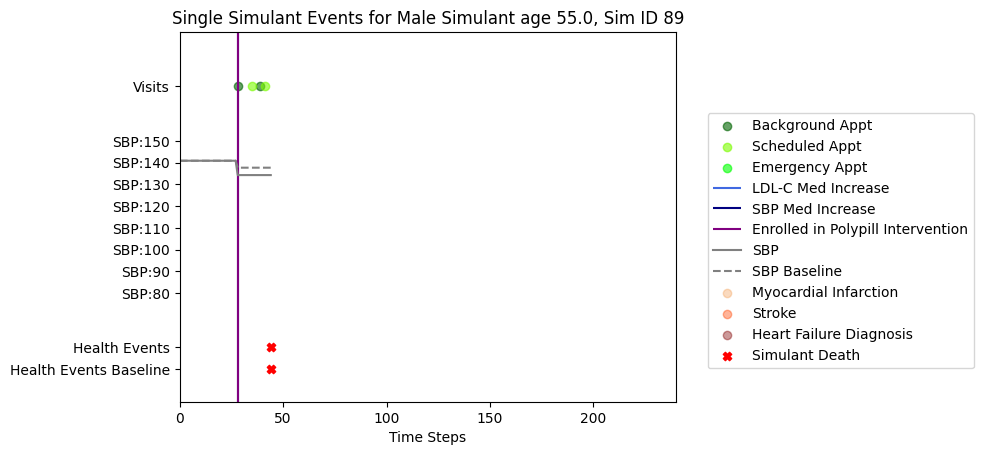

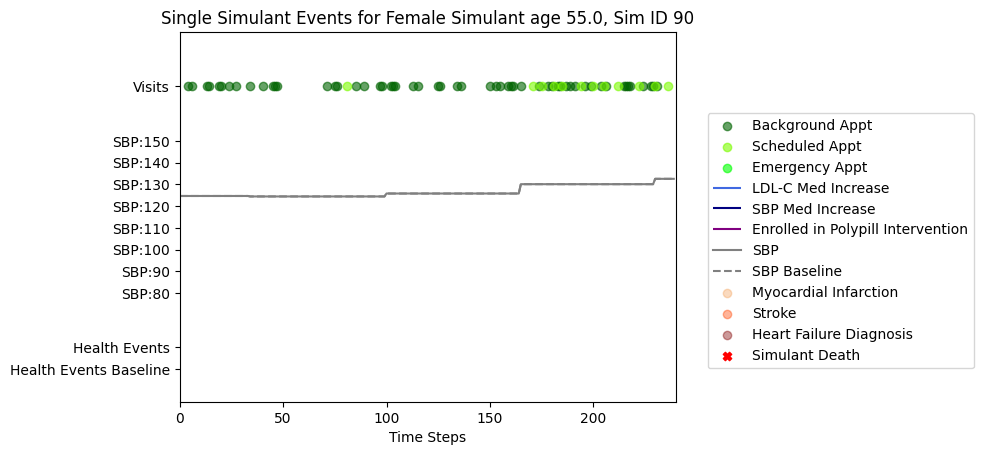

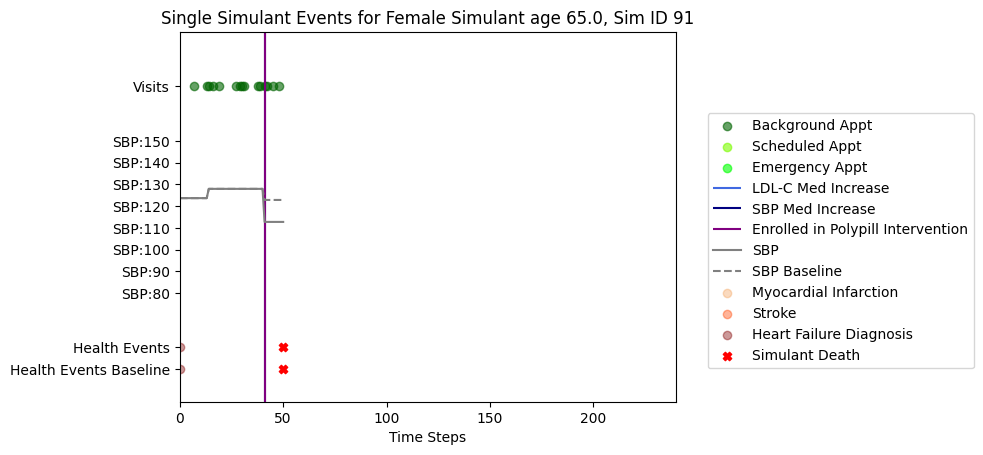

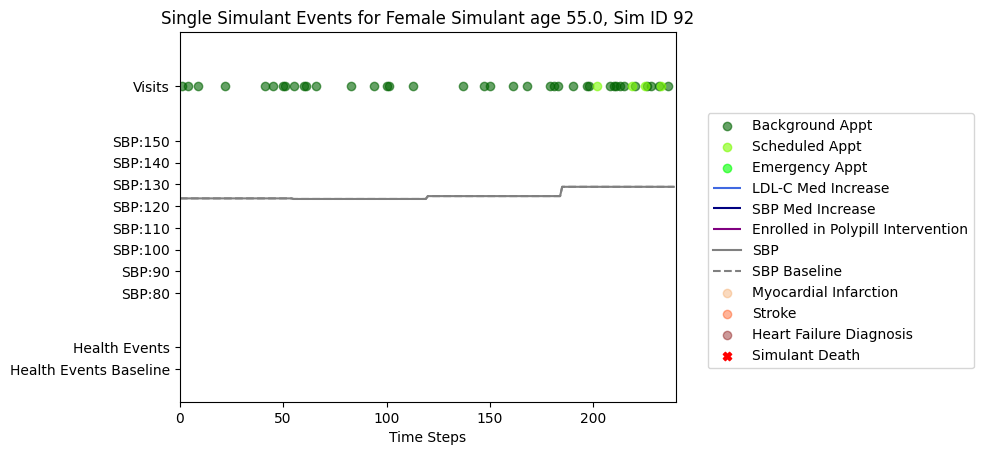

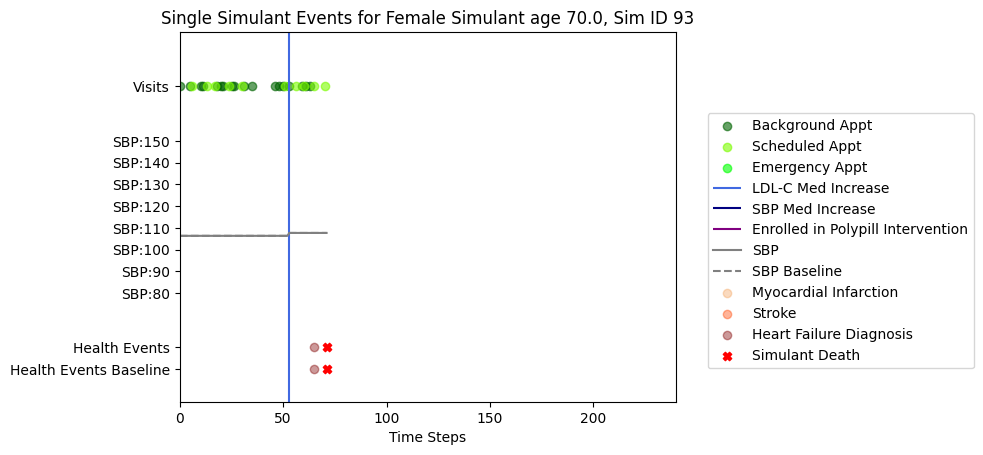

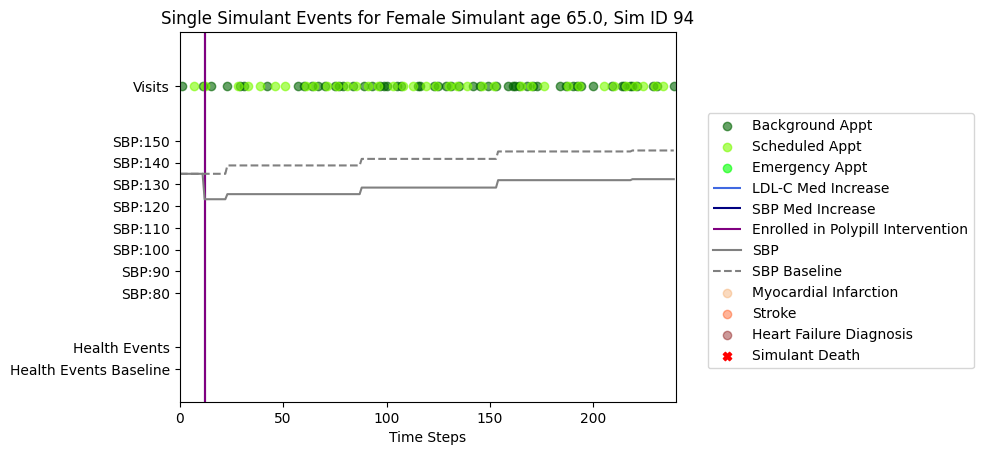

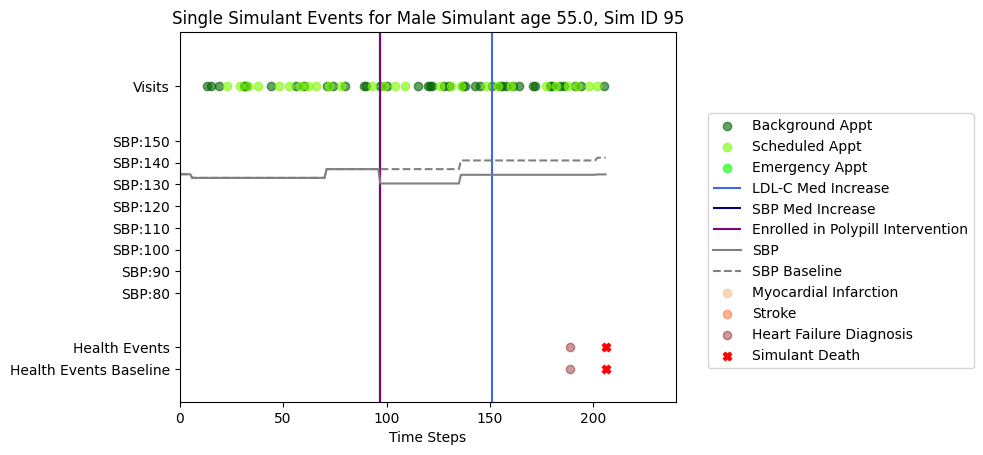

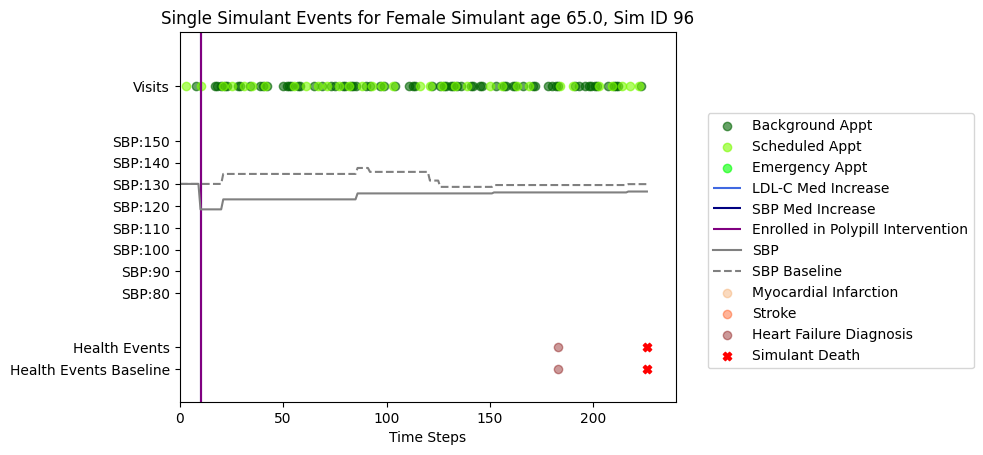

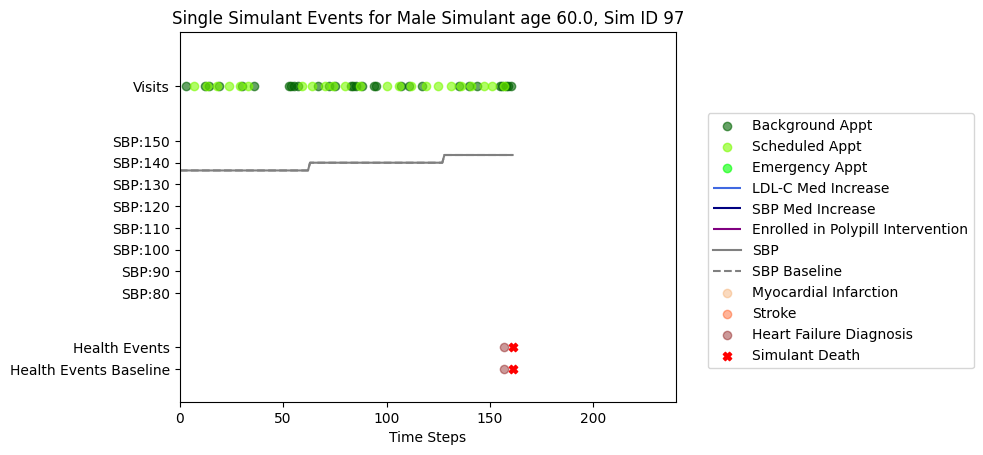

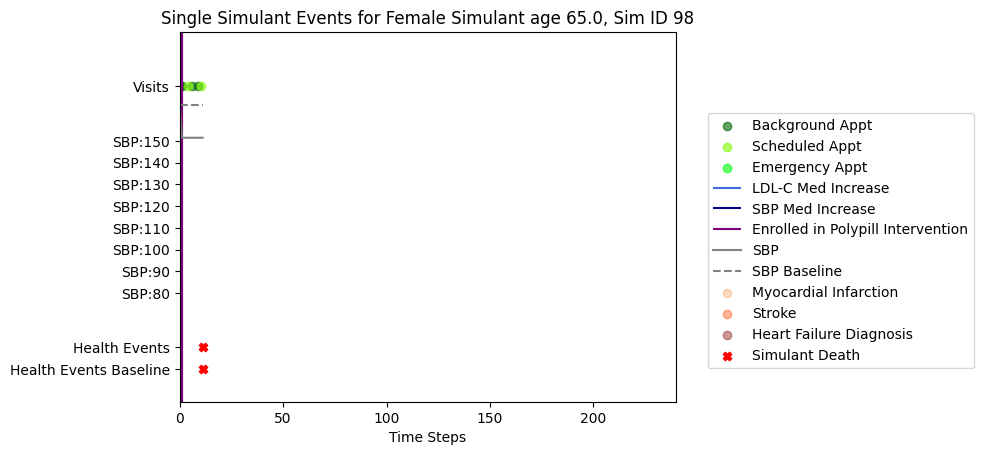

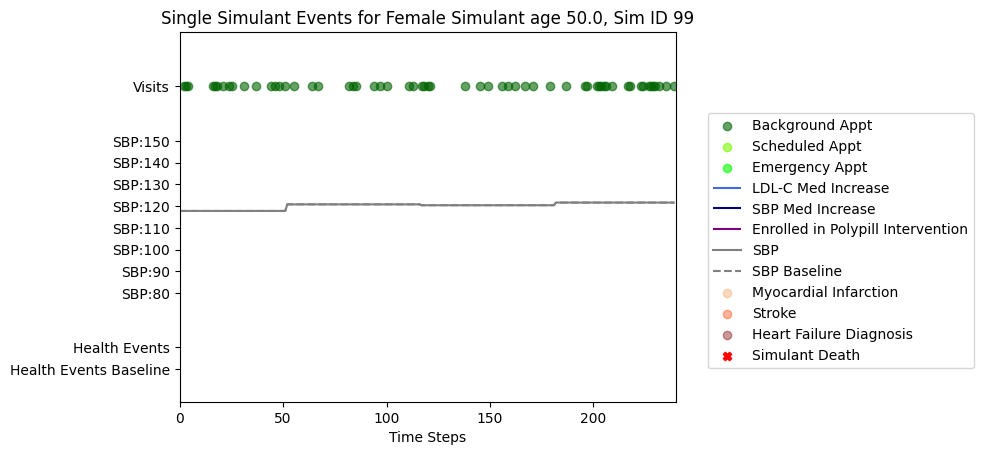

In [92]:
## Polypill Graphs - only include SBP

with PdfPages('single_sim_polypill_counterfactual.pdf') as pdf:
    for sim_id in event_data_polypill.sim_id.unique():
        single_sim = event_data_polypill.loc[(event_data_polypill['sim_id']==sim_id)]
        single_sim_baseline = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        died_b, died_y_b, MI_b, MI_y_b, HF_b, HF_y_b, stroke_b, stroke_y_b = health_events_baseline(single_sim_baseline)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        polypill = polypill_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        sbp_b, sbp_base_b = sbp_func(single_sim_baseline)
        risks_y = single_sim.step.values.tolist()
        risks_y_b = single_sim_baseline.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            risks_y_b[:] = [x for x in risks_y_b if x <= died_b]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            sbp_b = sbp_b[:died_b+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits','SBP:150','SBP:140','SBP:130','SBP:120','SBP:110','SBP:100','SBP:90','SBP:80','Health Events', 'Health Events Baseline']
        y_ticks = [175,150,140,130,120,110,100,90,80,55,45]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 30, ymax = 200, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 30, ymax = 200, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = polypill, ymin = 30, ymax = 200, colors = 'purple', label = 'Enrolled in Polypill Intervention')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y_b, sbp_b, c='gray', linestyle='dashed', label = 'SBP Baseline')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.scatter(MI_b, MI_y_b, c='sandybrown', alpha = 0.4)
        plt.scatter(stroke_b, stroke_y_b, c='orangered', alpha = 0.4)
        plt.scatter(HF_b, HF_y_b, c='maroon', alpha = 0.4)
        plt.scatter(died_b, died_y_b, c='red', marker='X',)
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(30,200)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

In [ ]:
## Outreach Graphs - only include SBP and LDL-C 

with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

## Risk Comparison Graphs

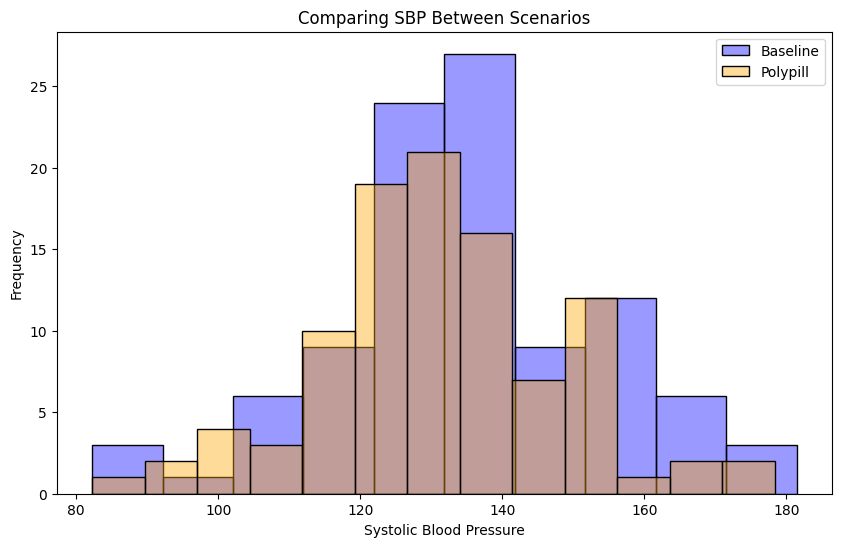

In [13]:
last_time = test_data.loc[test_data.step == 50]
last_time_poly = test_data_polypill.loc[test_data_polypill.step == 50]

plt.figure(figsize=(10, 6))
ax = plt.gca()

sns.histplot(data=last_time, x='high_sbp', color='blue', alpha=0.4, label='Baseline')
sns.histplot(data=last_time_poly, x='high_sbp', color='orange', alpha=0.4, label='Polypill')

plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Frequency')
plt.title('Comparing SBP Between Scenarios')
plt.legend()
plt.show()